### Importe de librerias 


In [1]:
#Para poner la barra de progreso durante el entrenamiento 
!pip install tqdm
import sys
!"{sys.executable}" -m pip install tqdm 

In [2]:
import pennylane as qml
import numpy as np
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import random
import pickle
from scipy.stats import truncnorm
import math

### Definición del dispositivo y número de qubits

Un dispositivo cuántico es un objeto que representa el backend donde se ejecuta el circuito cuántico.

qml.device carga un dispositivo cuántico particular.

'default.qubit':un simulador de estados puros.

'default.mixed':un simulador de estados mezclados.

In [3]:
#Definición del dispositivo cuántico
dev = qml.device("default.mixed", wires=4)

### Arquitectura del Circuito 


Un QNode es una función que contiene al circuito variacional y el dispositivo computacional en el que se ejecuta.

interface="autograd": le dice a PennyLane que los parámetros serán diferenciables con autograd (la librería automática de derivación).

qml.QubitDensityMatrix requiere el estado total del sistema completo.

Toma el estado base (qubits 0 y 1 en |00⟩⟨00|) y lo combina con el estado rho (en qubits 2 y 3) para formar el estado de los 4 qubits juntos.


In [4]:

@qml.qnode(dev) #Decorador para definir el circuito cuántico
def Circuit(params, rho):
    # Crear estado |00⟩⟨00| para qubits 0 y 1
    base = pnp.zeros((4,4), dtype=complex)
    base[0,0] = 1.0 # Para poner la primera entrada de la matriz en 1 y el resto en 0
    
    # Producto tensorial para obtener estado total de 4 qubits
    full_state = pnp.kron(base, rho)
    
    # Usar en el dispositivo de 4 qubits
    qml.QubitDensityMatrix(full_state, wires=[0, 1, 2, 3])
    
    qml.Rot(params[0], params[1], params[2], wires=0)
    qml.Rot(params[3], params[4], params[5], wires=1)
    qml.Rot(params[6], params[7], params[8], wires=2)
    qml.Rot(params[9], params[10], params[11], wires=3)
    
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[0, 2])
    qml.CNOT(wires=[0, 3])
    qml.CNOT(wires=[3, 0])

    # La compuerta v1 opera si el qubit de control (0) está en |1⟩


    qml.PauliX(wires=0)

    qml.ctrl(qml.Rot(params[12], params[13], params[14], wires=1), control=0)
    qml.ctrl(qml.Rot(params[15], params[16], params[17], wires=2), control=0)
    qml.ctrl(qml.Rot(params[18], params[19], params[20], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)

    qml.PauliX(wires=0)

    # La compuerta v2 opera si el qubit de control (0) está en |0⟩


    qml.ctrl(qml.Rot(params[21], params[22], params[23], wires=1), control=0)
    qml.ctrl(qml.Rot(params[24], params[25], params[26], wires=2), control=0)
    qml.ctrl(qml.Rot(params[27], params[28], params[29], wires=3), control=0)
        
    
    qml.ctrl(qml.CNOT(wires=[1, 2]), control=0)
    qml.ctrl(qml.CNOT(wires=[1, 3]), control=0)
    qml.ctrl(qml.CNOT(wires=[3, 1]), control=0)    
    
    return qml.probs(wires=[0, 1]) 



### Definición de las familias 

dtype= complex porque aunque las matrices se definan para parametros a y b reales, 
la evolución del sistema si puede introducir números complejos.

In [5]:
def ρ1(a):
    
    psi1 = pnp.array([np.sqrt(1 - a*a), 0.0, a, 0.0], dtype=complex)
    rho1 = pnp.outer(psi1, psi1.conj())
    return rho1, 1

def ρ2(b):

    psi2 = pnp.array([0.0, np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    psi3 = pnp.array([0.0, -np.sqrt(1 - b*b), b, 0.0], dtype=complex)
    rho2 = 0.5 * np.outer(psi2, psi2.conj()) + 0.5 * np.outer(psi3, psi3.conj())

    return rho2, 2
    

### Conjunto de Datos de Prueba 

Para el caso de la distribución uniforme

In [6]:
np.random.seed(2)
n_test = 10000
data_test = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_test//3)

for a in a_values:
    rho, label = ρ1(a)
    data_test.append((rho, label))

b_test = np.random.uniform(0, 1, math.ceil(n_test*(2/3)))
for b in b_test:
    rho, label = ρ2(b)
    data_test.append((rho, label))

### Conjunto de Datos de Entrenamiento 


In [7]:
np.random.seed(90701)
n_samples = 1000
data = []

def sample_truncated_normal(mean, std, size):
    a, b = (0 - mean) / std, (1 - mean) / std
    return truncnorm(a, b, loc=mean, scale=std).rvs(size)

a_values = sample_truncated_normal(mean=0.25, std=0.05, size=n_samples//3)
for a in a_values:
    rho, label = ρ1(a)
    data.append((rho, label))  


b_values = np.random.uniform(0, 1, math.ceil(n_samples*(2/3)))
for b in b_values:
    rho, label = ρ2(b)
    data.append((rho, label))

data_train, data_val = train_test_split(data, test_size=0.2, random_state=42)

### Función de Pérdida 


In [8]:
# Funciones de pérdida

# Clasificación mínimo error (Probabilidad de inconclusión casi nula)

alpha_err = 25  # penaliza los errores
alpha_inc = 2 # penaliza los resultados inconclusos


# Función de pérdida para una muestra según el label:
# label 1: familia 1 se espera que los outcomes 00 y 10 sean correctos.
# label 2: familia 2 se espera que el outcome 01 sea correcto.

def sample_loss(params, rho, label):
    
    probs = Circuit(params, rho)
    # |00> -> probs[0], |01> -> probs[1], |10> -> probs[2], |11> -> probs[3]
    if label == 1:
        # Familia 1 => éxito: (|00>, |10>), error: |01>, inconcluso: |11>
        p_suc = (probs[0] + probs[2])
        p_err = probs[1]
        p_inc = probs[3]
    else:
        # Familia 2 => éxito: |01>, error: (|00>, |10>), inconcluso: |11>
        p_suc = probs[1]
        p_err = probs[0] + probs[2]
        p_inc = probs[3]
        
    return (
    pnp.abs(p_suc - 1.0)
    + alpha_err * pnp.abs(p_err - 0.0)
    + alpha_inc * pnp.abs(p_inc - 0.0)
    )

# Función global de pérdida que promedia sobre el conjunto de muestras

def loss(params, samples):
    total = pnp.array(0.0, requires_grad=True) #iniciar el acumulador del costo total,
    #asegurar que ese acumulador soporta derivación automática, y permitir que luego PennyLane optimice los parámetros con gradientes.  

    for (rho, label) in samples:
        total = total + sample_loss(params, rho, label)

    avg = total / len(samples)           
    return avg  

In [9]:
def get_probabilities(params, rho, label):
    """Calcula las probabilidades de salida del circuito, dada la matriz de densidad."""
    
    return Circuit(params, rho)


### Evaluación del modelo

In [10]:
def evaluate_model(params, samples):
    """Evalúa tasas promedio de éxito, error e inconcluso en cada familia."""
    
    # Separar por familia
    S1 = [rho for (rho, label) in samples if label == 1]
    S2 = [rho for (rho, label) in samples if label == 2]

    total_suc_1, total_err_1, total_inc_1 = 0, 0, 0
    total_suc_2, total_err_2, total_inc_2 = 0, 0, 0

    for rho in S1:
        probs = get_probabilities(params, rho, 1)
        total_suc_1 += probs[0] + probs[2]  # éxito
        total_err_1 += probs[1]
        total_inc_1 += probs[3]

    for rho in S2:
        probs = get_probabilities(params, rho, 2)
        total_suc_2 += probs[1]             # éxito
        total_err_2 += probs[0] + probs[2]
        total_inc_2 += probs[3]

    # Promedios por familia
    n1, n2 = len(S1), len(S2)
    suc = (total_suc_1 + total_suc_2) / (n1 + n2)
    err = (total_err_1 + total_err_2) / (n1 + n2)
    inc = (total_inc_1 + total_inc_2) / (n1 + n2)

    return suc, err, inc


In [11]:
def get_batches(data, batch_size):
    # Asegurar que batch_size sea al menos 1
    batch_size = max(1, int(batch_size))
    
    # Mezclar los datos
    data_shuffled = random.sample(data, len(data))
    
    # Crear los lotes
    return [data_shuffled[i:i+batch_size] for i in range(0, len(data), batch_size)]


### Entrenamiento del modelo


params, curr_loss = opt.step_and_cost(lambda v: loss(v, data_train), params)

opt: Optimizador
.step_and_cost(...): Método que actualiza los parámetros y devuelve el valor de la función de costo


Calcula el valor de la función de la función de costo (loss(...)) para los parámetros actuales.
Calcula el gradiente de esa función de costo con respecto a los parámetros.
Actualiza los parámetros en la dirección que reduce la función de costo.

Devuelve:

params: los nuevos parámetros después de actualizar.

curr_loss: el valor actual de la función de costo.

La función lambda hace que el optimizador calcule la función de costo con los parámetros v usando el conjunto de datos data_train que ya está fijado.



In [12]:
opt = qml.AdamOptimizer(stepsize=0.01)
n_iter = 5000
batch_size = int(len(data_train) * 0.2)
val_batch_size = int(0.2 * batch_size)

initial_params = np.random.uniform(0, 2 * np.pi, 30)
params = pnp.array(initial_params, requires_grad=True)

# Early stopping
patience = 500
min_delta = 1e-4
best_val_loss = float('inf')
patience_counter = 0
best_params = params.copy()  # Guardar los mejores parámetros

# ReduceLROnPlateau
plateau_patience = 150
plateau_factor = 0.5
min_lr = 1e-5
plateau_counter = 0

# Historiales
loss_history = []
val_loss_history = []
train_suc_history = []
train_err_history = []
train_inc_history = []
val_suc_history = []
val_err_history = []
val_inc_history = []

for it in tqdm(range(n_iter), desc="Entrenando"):

    # Batch aleatorio
    batch = random.sample(data_train, batch_size)

    # Paso de entrenamiento
    params, train_loss = opt.step_and_cost(lambda v: loss(v, batch), params)

    # Evaluación en validación
    val_batches = get_batches(data_val, val_batch_size)
    val_loss = 0
    for vb in val_batches:
        val_loss += loss(params, vb) * len(vb)
    val_loss /= len(data_val)

    # EARLY STOPPING 
    if val_loss < best_val_loss - min_delta:  # Mejora significativa
        best_val_loss = val_loss
        best_params = params.copy()  # Guardar mejores parámetros
        patience_counter = 0
        plateau_counter = 0  # reinicia ambos contadores
    else:
        patience_counter += 1
        plateau_counter += 1

    # REDUCE LR ON PLATEAU 
    if plateau_counter >= plateau_patience:
        new_lr = max(opt.stepsize * plateau_factor, min_lr)
        if new_lr < opt.stepsize:
            print(f"Reducción de learning rate: {opt.stepsize:.5f} → {new_lr:.5f}")
            opt.stepsize = new_lr
            plateau_counter = 0  # Reiniciar después de reducir LR

    # STOPPING 
    if patience_counter >= patience:
        print(f"Early stopping en iteración {it+1}. Mejor pérdida de validación: {best_val_loss:.6f}")
        params = best_params  # Restaurar mejores parámetros
        break

    # Evaluación en train, test y validación
    suc_train, err_train, inc_train = evaluate_model(params, data_train)
    suc_val, err_val, inc_val = evaluate_model(params, data_val)


    # Guardar métricas
    loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    train_suc_history.append(suc_train)
    train_err_history.append(err_train)
    train_inc_history.append(inc_train)
    val_suc_history.append(suc_val)
    val_err_history.append(err_val)
    val_inc_history.append(inc_val)

    if (it + 1) % 50 == 0:
        print(f"Iter {it+1:3d}: train_loss={train_loss:.4f}, val_loss={val_loss:.4f}, "
              f"train_suc={suc_train:.3f}, train_err={err_train:.3f}, train_inc={inc_train:.3f} | "
              f"val_suc={suc_val:.3f}, val_err={err_val:.3f}, val_inc={inc_val:.3f}") 
    if (it + 1) % 100 == 0:
        print(f"Iter {it+1}: LR actual = {opt.stepsize:.6f}")

# Usar los mejores parámetros al final
params = best_params

# Final
print("\nParámetros entrenados:")
print(params)

print("\nResultados finales en el conjunto de prueba:")
test_suc, test_err, test_inc = evaluate_model(params, data_test)
print(f"  Éxito promedio     = {test_suc:.4f}")
print(f"  Error promedio     = {test_err:.4f}")
print(f"  Inconcluso promedio = {test_inc:.4f}")




Entrenando:   0%|          | 0/5000 [00:00<?, ?it/s]

Entrenando:   0%|          | 1/5000 [01:15<105:09:20, 75.73s/it]

Entrenando:   0%|          | 2/5000 [02:32<106:09:52, 76.47s/it]

Entrenando:   0%|          | 3/5000 [03:47<104:47:44, 75.50s/it]

Entrenando:   0%|          | 4/5000 [05:01<104:04:14, 74.99s/it]

Entrenando:   0%|          | 5/5000 [06:14<103:21:45, 74.50s/it]

Entrenando:   0%|          | 6/5000 [07:28<103:09:25, 74.36s/it]

Entrenando:   0%|          | 7/5000 [08:42<102:49:35, 74.14s/it]

Entrenando:   0%|          | 8/5000 [09:55<102:23:19, 73.84s/it]

Entrenando:   0%|          | 9/5000 [11:07<101:32:16, 73.24s/it]

Entrenando:   0%|          | 10/5000 [12:41<110:18:27, 79.58s/it]

Entrenando:   0%|          | 11/5000 [14:22<119:12:00, 86.01s/it]

Entrenando:   0%|          | 12/5000 [16:21<133:16:09, 96.18s/it]

Entrenando:   0%|          | 13/5000 [18:24<144:37:12, 104.40s/it]

Entrenando:   0%|          | 14/5000 [20:33<154:31:08, 111.57s/it]

Entrenando:   0%|          | 15/5000 [22:31<157:11:57, 113.52s/it]

Entrenando:   0%|          | 16/5000 [24:27<158:32:02, 114.51s/it]

Entrenando:   0%|          | 17/5000 [26:39<165:35:10, 119.63s/it]

Entrenando:   0%|          | 18/5000 [29:24<184:36:17, 133.40s/it]

Entrenando:   0%|          | 19/5000 [32:26<204:32:24, 147.83s/it]

Entrenando:   0%|          | 20/5000 [35:25<217:18:32, 157.09s/it]

Entrenando:   0%|          | 21/5000 [38:39<232:37:07, 168.19s/it]

Entrenando:   0%|          | 22/5000 [41:32<234:40:03, 169.71s/it]

Entrenando:   0%|          | 23/5000 [44:55<248:18:07, 179.60s/it]

Entrenando:   0%|          | 24/5000 [48:11<255:20:48, 184.74s/it]

Entrenando:   0%|          | 25/5000 [52:05<275:49:20, 199.59s/it]

Entrenando:   1%|          | 26/5000 [56:05<292:14:27, 211.51s/it]

Entrenando:   1%|          | 27/5000 [59:52<298:44:44, 216.26s/it]

Entrenando:   1%|          | 28/5000 [1:03:40<303:30:11, 219.75s/it]

Entrenando:   1%|          | 29/5000 [1:07:26<306:00:21, 221.61s/it]

Entrenando:   1%|          | 30/5000 [1:11:14<308:27:02, 223.43s/it]

Entrenando:   1%|          | 31/5000 [1:15:01<310:06:14, 224.67s/it]

Entrenando:   1%|          | 32/5000 [1:18:47<310:40:25, 225.13s/it]

Entrenando:   1%|          | 33/5000 [1:22:41<314:10:30, 227.71s/it]

Entrenando:   1%|          | 34/5000 [1:26:43<319:52:15, 231.88s/it]

Entrenando:   1%|          | 35/5000 [1:30:41<322:34:01, 233.89s/it]

Entrenando:   1%|          | 36/5000 [1:34:35<322:19:31, 233.76s/it]

Entrenando:   1%|          | 37/5000 [1:38:33<324:11:19, 235.16s/it]

Entrenando:   1%|          | 38/5000 [1:42:07<315:27:18, 228.87s/it]

Entrenando:   1%|          | 39/5000 [1:45:35<306:31:40, 222.44s/it]

Entrenando:   1%|          | 40/5000 [1:48:50<295:02:36, 214.14s/it]

Entrenando:   1%|          | 41/5000 [1:51:48<280:04:39, 203.32s/it]

Entrenando:   1%|          | 42/5000 [1:54:52<272:00:45, 197.51s/it]

Entrenando:   1%|          | 43/5000 [1:57:45<262:07:31, 190.37s/it]

Entrenando:   1%|          | 44/5000 [2:00:43<256:37:54, 186.42s/it]

Entrenando:   1%|          | 45/5000 [2:03:39<252:27:45, 183.42s/it]

Entrenando:   1%|          | 46/5000 [2:06:38<250:29:25, 182.03s/it]

Entrenando:   1%|          | 47/5000 [2:09:41<251:05:05, 182.50s/it]

Entrenando:   1%|          | 48/5000 [2:12:51<254:05:55, 184.72s/it]

Entrenando:   1%|          | 49/5000 [2:15:52<252:13:18, 183.40s/it]

Entrenando:   1%|          | 50/5000 [2:18:43<247:13:20, 179.80s/it]

Iter  50: train_loss=4.8431, val_loss=5.2529, train_suc=0.669, train_err=0.176, train_inc=0.155 | val_suc=0.652, val_err=0.183, val_inc=0.165


Entrenando:   1%|          | 51/5000 [2:21:46<248:26:09, 180.72s/it]

Entrenando:   1%|          | 52/5000 [2:24:32<242:19:49, 176.31s/it]

Entrenando:   1%|          | 53/5000 [2:27:09<234:15:17, 170.47s/it]

Entrenando:   1%|          | 54/5000 [2:29:43<227:32:29, 165.62s/it]

Entrenando:   1%|          | 55/5000 [2:32:16<222:14:00, 161.79s/it]

Entrenando:   1%|          | 56/5000 [2:34:48<218:13:51, 158.91s/it]

Entrenando:   1%|          | 57/5000 [2:37:18<214:29:19, 156.21s/it]

Entrenando:   1%|          | 58/5000 [2:39:45<210:39:03, 153.45s/it]

Entrenando:   1%|          | 59/5000 [2:42:17<209:56:06, 152.96s/it]

Entrenando:   1%|          | 60/5000 [2:44:32<202:45:51, 147.76s/it]

Entrenando:   1%|          | 61/5000 [2:46:43<195:28:08, 142.48s/it]

Entrenando:   1%|          | 62/5000 [2:48:53<190:19:52, 138.76s/it]

Entrenando:   1%|▏         | 63/5000 [2:51:01<185:50:22, 135.51s/it]

Entrenando:   1%|▏         | 64/5000 [2:52:54<176:46:43, 128.93s/it]

Entrenando:   1%|▏         | 65/5000 [2:54:49<170:59:30, 124.74s/it]

Entrenando:   1%|▏         | 66/5000 [2:56:50<169:20:02, 123.55s/it]

Entrenando:   1%|▏         | 67/5000 [2:58:46<166:18:25, 121.37s/it]

Entrenando:   1%|▏         | 68/5000 [3:00:49<166:59:33, 121.89s/it]

Entrenando:   1%|▏         | 69/5000 [3:02:50<166:29:14, 121.55s/it]

Entrenando:   1%|▏         | 70/5000 [3:04:53<166:50:38, 121.83s/it]

Entrenando:   1%|▏         | 71/5000 [3:06:55<166:59:54, 121.97s/it]

Entrenando:   1%|▏         | 72/5000 [3:08:52<164:50:41, 120.42s/it]

Entrenando:   1%|▏         | 73/5000 [3:10:56<166:16:05, 121.49s/it]

Entrenando:   1%|▏         | 74/5000 [3:13:00<167:22:08, 122.32s/it]

Entrenando:   2%|▏         | 75/5000 [3:14:47<160:55:17, 117.63s/it]

Entrenando:   2%|▏         | 76/5000 [3:16:49<162:59:03, 119.16s/it]

Entrenando:   2%|▏         | 77/5000 [3:18:48<162:47:30, 119.04s/it]

Entrenando:   2%|▏         | 78/5000 [3:20:39<159:31:21, 116.68s/it]

Entrenando:   2%|▏         | 79/5000 [3:22:36<159:33:50, 116.73s/it]

Entrenando:   2%|▏         | 80/5000 [3:24:27<157:03:57, 114.93s/it]

Entrenando:   2%|▏         | 81/5000 [3:26:26<158:43:07, 116.16s/it]

Entrenando:   2%|▏         | 82/5000 [3:28:27<160:37:06, 117.57s/it]

Entrenando:   2%|▏         | 83/5000 [3:30:20<158:53:08, 116.33s/it]

Entrenando:   2%|▏         | 84/5000 [3:32:24<162:05:09, 118.70s/it]

Entrenando:   2%|▏         | 85/5000 [3:34:19<160:24:29, 117.49s/it]

Entrenando:   2%|▏         | 86/5000 [3:36:17<160:25:57, 117.53s/it]

Entrenando:   2%|▏         | 87/5000 [3:38:13<159:51:46, 117.14s/it]

Entrenando:   2%|▏         | 88/5000 [3:40:11<160:06:59, 117.35s/it]

Entrenando:   2%|▏         | 89/5000 [3:42:10<160:53:30, 117.94s/it]

Entrenando:   2%|▏         | 90/5000 [3:44:12<162:22:57, 119.06s/it]

Entrenando:   2%|▏         | 91/5000 [3:46:16<164:35:08, 120.70s/it]

Entrenando:   2%|▏         | 92/5000 [3:48:22<166:50:25, 122.38s/it]

Entrenando:   2%|▏         | 93/5000 [3:50:19<164:32:17, 120.71s/it]

Entrenando:   2%|▏         | 94/5000 [3:52:12<161:22:29, 118.42s/it]

Entrenando:   2%|▏         | 95/5000 [3:54:11<161:17:01, 118.37s/it]

Entrenando:   2%|▏         | 96/5000 [3:56:17<164:32:56, 120.79s/it]

Entrenando:   2%|▏         | 97/5000 [3:58:17<164:11:59, 120.56s/it]

Entrenando:   2%|▏         | 98/5000 [4:00:14<162:49:13, 119.57s/it]

Entrenando:   2%|▏         | 99/5000 [4:02:11<161:29:20, 118.62s/it]

Entrenando:   2%|▏         | 100/5000 [4:04:06<160:09:30, 117.67s/it]

Iter 100: train_loss=2.5410, val_loss=2.4932, train_suc=0.670, train_err=0.060, train_inc=0.269 | val_suc=0.650, val_err=0.063, val_inc=0.287
Iter 100: LR actual = 0.010000


Entrenando:   2%|▏         | 101/5000 [4:06:06<160:52:16, 118.22s/it]

Entrenando:   2%|▏         | 102/5000 [4:08:13<164:31:44, 120.93s/it]

Entrenando:   2%|▏         | 103/5000 [4:10:12<163:44:44, 120.38s/it]

Entrenando:   2%|▏         | 104/5000 [4:12:00<158:48:43, 116.77s/it]

Entrenando:   2%|▏         | 105/5000 [4:14:01<160:22:42, 117.95s/it]

Entrenando:   2%|▏         | 106/5000 [4:15:56<158:59:29, 116.95s/it]

Entrenando:   2%|▏         | 107/5000 [4:17:47<156:49:09, 115.38s/it]

Entrenando:   2%|▏         | 108/5000 [4:19:50<159:37:17, 117.46s/it]

Entrenando:   2%|▏         | 109/5000 [4:21:38<155:44:32, 114.63s/it]

Entrenando:   2%|▏         | 110/5000 [4:23:31<155:14:25, 114.29s/it]

Entrenando:   2%|▏         | 111/5000 [4:25:29<156:29:40, 115.23s/it]

Entrenando:   2%|▏         | 112/5000 [4:27:19<154:30:49, 113.80s/it]

Entrenando:   2%|▏         | 113/5000 [4:29:09<153:00:26, 112.71s/it]

Entrenando:   2%|▏         | 114/5000 [4:31:12<156:52:04, 115.58s/it]

Entrenando:   2%|▏         | 115/5000 [4:33:01<154:11:19, 113.63s/it]

Entrenando:   2%|▏         | 116/5000 [4:35:12<161:18:35, 118.90s/it]

Entrenando:   2%|▏         | 117/5000 [4:37:12<161:46:53, 119.27s/it]

Entrenando:   2%|▏         | 118/5000 [4:39:14<163:00:15, 120.20s/it]

Entrenando:   2%|▏         | 119/5000 [4:41:14<162:54:34, 120.15s/it]

Entrenando:   2%|▏         | 120/5000 [4:43:16<163:30:46, 120.62s/it]

Entrenando:   2%|▏         | 121/5000 [4:45:18<163:50:22, 120.89s/it]

Entrenando:   2%|▏         | 122/5000 [4:47:21<164:35:28, 121.47s/it]

Entrenando:   2%|▏         | 123/5000 [4:49:18<162:51:28, 120.22s/it]

Entrenando:   2%|▏         | 124/5000 [4:51:11<160:09:52, 118.25s/it]

Entrenando:   2%|▎         | 125/5000 [4:53:17<162:54:50, 120.31s/it]

Entrenando:   3%|▎         | 126/5000 [4:55:11<160:28:53, 118.53s/it]

Entrenando:   3%|▎         | 127/5000 [4:57:14<162:05:16, 119.74s/it]

Entrenando:   3%|▎         | 128/5000 [4:59:19<164:16:39, 121.39s/it]

Entrenando:   3%|▎         | 129/5000 [5:01:18<163:27:22, 120.81s/it]

Entrenando:   3%|▎         | 130/5000 [5:03:19<163:24:58, 120.80s/it]

Entrenando:   3%|▎         | 131/5000 [5:05:29<167:17:23, 123.69s/it]

Entrenando:   3%|▎         | 132/5000 [5:08:23<187:29:33, 138.66s/it]

Entrenando:   3%|▎         | 133/5000 [5:11:51<215:25:18, 159.34s/it]

Entrenando:   3%|▎         | 134/5000 [5:15:14<233:21:28, 172.64s/it]

Entrenando:   3%|▎         | 135/5000 [5:18:36<245:03:30, 181.34s/it]

Entrenando:   3%|▎         | 136/5000 [5:21:52<251:07:21, 185.86s/it]

Entrenando:   3%|▎         | 137/5000 [5:25:12<256:47:44, 190.10s/it]

Entrenando:   3%|▎         | 138/5000 [5:28:33<260:57:22, 193.22s/it]

Entrenando:   3%|▎         | 139/5000 [5:32:06<268:58:43, 199.20s/it]

Entrenando:   3%|▎         | 140/5000 [5:35:40<275:06:39, 203.79s/it]

Entrenando:   3%|▎         | 141/5000 [5:39:23<282:33:27, 209.35s/it]

Entrenando:   3%|▎         | 142/5000 [5:43:05<287:47:06, 213.26s/it]

Entrenando:   3%|▎         | 143/5000 [5:46:41<288:47:08, 214.05s/it]

Entrenando:   3%|▎         | 144/5000 [5:50:13<287:54:50, 213.45s/it]

Entrenando:   3%|▎         | 145/5000 [5:53:48<288:14:12, 213.73s/it]

Entrenando:   3%|▎         | 146/5000 [5:57:23<288:55:52, 214.29s/it]

Entrenando:   3%|▎         | 147/5000 [6:00:57<288:44:26, 214.19s/it]

Entrenando:   3%|▎         | 148/5000 [6:04:36<290:40:55, 215.67s/it]

Entrenando:   3%|▎         | 149/5000 [6:08:19<293:21:49, 217.71s/it]

Entrenando:   3%|▎         | 150/5000 [6:11:57<293:38:21, 217.96s/it]

Iter 150: train_loss=0.9349, val_loss=1.0413, train_suc=0.691, train_err=0.002, train_inc=0.307 | val_suc=0.671, val_err=0.002, val_inc=0.326


Entrenando:   3%|▎         | 151/5000 [6:15:35<293:25:37, 217.85s/it]

Entrenando:   3%|▎         | 152/5000 [6:19:10<292:19:49, 217.08s/it]

Entrenando:   3%|▎         | 153/5000 [6:22:35<287:32:43, 213.57s/it]

Entrenando:   3%|▎         | 154/5000 [6:25:51<280:01:31, 208.03s/it]

Entrenando:   3%|▎         | 155/5000 [6:28:51<268:39:56, 199.63s/it]

Entrenando:   3%|▎         | 156/5000 [6:31:53<261:28:25, 194.32s/it]

Entrenando:   3%|▎         | 157/5000 [6:34:47<253:24:48, 188.37s/it]

Entrenando:   3%|▎         | 158/5000 [6:37:55<253:17:10, 188.32s/it]

Entrenando:   3%|▎         | 159/5000 [6:40:57<250:34:31, 186.34s/it]

Entrenando:   3%|▎         | 160/5000 [6:43:38<240:29:36, 178.88s/it]

Entrenando:   3%|▎         | 161/5000 [6:46:21<233:41:34, 173.86s/it]

Entrenando:   3%|▎         | 162/5000 [6:48:54<225:19:54, 167.67s/it]

Entrenando:   3%|▎         | 163/5000 [6:51:15<214:37:19, 159.74s/it]

Entrenando:   3%|▎         | 164/5000 [6:53:45<210:49:26, 156.94s/it]

Entrenando:   3%|▎         | 165/5000 [6:56:05<203:45:56, 151.72s/it]

Entrenando:   3%|▎         | 166/5000 [6:58:25<198:59:41, 148.20s/it]

Entrenando:   3%|▎         | 167/5000 [7:00:44<195:23:56, 145.55s/it]

Entrenando:   3%|▎         | 168/5000 [7:02:58<190:32:14, 141.96s/it]

Entrenando:   3%|▎         | 169/5000 [7:05:16<188:54:01, 140.77s/it]

Entrenando:   3%|▎         | 170/5000 [7:07:26<184:32:09, 137.54s/it]

Entrenando:   3%|▎         | 171/5000 [7:09:38<182:26:46, 136.01s/it]

Entrenando:   3%|▎         | 172/5000 [7:11:55<182:48:14, 136.31s/it]

Entrenando:   3%|▎         | 173/5000 [7:14:06<180:40:33, 134.75s/it]

Entrenando:   3%|▎         | 174/5000 [7:16:11<176:42:53, 131.82s/it]

Entrenando:   4%|▎         | 175/5000 [7:18:11<171:43:26, 128.13s/it]

Entrenando:   4%|▎         | 176/5000 [7:20:24<173:32:19, 129.51s/it]

Entrenando:   4%|▎         | 177/5000 [7:22:35<174:20:43, 130.14s/it]

Entrenando:   4%|▎         | 178/5000 [7:24:47<174:55:08, 130.59s/it]

Entrenando:   4%|▎         | 179/5000 [7:26:58<175:16:01, 130.88s/it]

Entrenando:   4%|▎         | 180/5000 [7:29:11<175:56:17, 131.41s/it]

Entrenando:   4%|▎         | 181/5000 [7:31:24<176:39:21, 131.97s/it]

Entrenando:   4%|▎         | 182/5000 [7:33:36<176:24:29, 131.81s/it]

Entrenando:   4%|▎         | 183/5000 [7:35:50<177:28:55, 132.64s/it]

Entrenando:   4%|▎         | 184/5000 [7:38:05<178:17:10, 133.27s/it]

Entrenando:   4%|▎         | 185/5000 [7:40:14<176:29:03, 131.95s/it]

Entrenando:   4%|▎         | 186/5000 [7:42:20<174:00:43, 130.13s/it]

Entrenando:   4%|▎         | 187/5000 [7:44:20<170:00:32, 127.16s/it]

Entrenando:   4%|▍         | 188/5000 [7:46:18<166:10:49, 124.32s/it]

Entrenando:   4%|▍         | 189/5000 [7:48:20<165:18:13, 123.69s/it]

Entrenando:   4%|▍         | 190/5000 [7:50:26<166:07:08, 124.33s/it]

Entrenando:   4%|▍         | 191/5000 [7:52:19<161:47:14, 121.11s/it]

Entrenando:   4%|▍         | 192/5000 [7:54:11<157:42:46, 118.09s/it]

Entrenando:   4%|▍         | 193/5000 [7:56:07<157:05:04, 117.64s/it]

Entrenando:   4%|▍         | 194/5000 [7:58:03<156:19:40, 117.10s/it]

Entrenando:   4%|▍         | 195/5000 [8:00:12<161:08:11, 120.73s/it]

Entrenando:   4%|▍         | 196/5000 [8:02:13<161:05:57, 120.72s/it]

Entrenando:   4%|▍         | 197/5000 [8:04:08<158:44:53, 118.99s/it]

Entrenando:   4%|▍         | 198/5000 [8:06:05<157:52:30, 118.36s/it]

Entrenando:   4%|▍         | 199/5000 [8:08:06<159:13:50, 119.40s/it]

Entrenando:   4%|▍         | 200/5000 [8:10:08<160:09:14, 120.12s/it]

Iter 200: train_loss=0.8338, val_loss=0.8841, train_suc=0.723, train_err=0.000, train_inc=0.276 | val_suc=0.707, val_err=0.000, val_inc=0.293
Iter 200: LR actual = 0.010000


Entrenando:   4%|▍         | 201/5000 [8:11:59<156:26:43, 117.36s/it]

Entrenando:   4%|▍         | 202/5000 [8:14:02<158:37:52, 119.02s/it]

Entrenando:   4%|▍         | 203/5000 [8:16:07<161:01:25, 120.84s/it]

Entrenando:   4%|▍         | 204/5000 [8:18:10<161:49:03, 121.46s/it]

Entrenando:   4%|▍         | 205/5000 [8:20:10<161:16:26, 121.08s/it]

Entrenando:   4%|▍         | 206/5000 [8:21:58<155:45:54, 116.97s/it]

Entrenando:   4%|▍         | 207/5000 [8:24:04<159:31:37, 119.82s/it]

Entrenando:   4%|▍         | 208/5000 [8:26:11<162:26:18, 122.03s/it]

Entrenando:   4%|▍         | 209/5000 [8:28:21<165:36:14, 124.44s/it]

Entrenando:   4%|▍         | 210/5000 [8:30:35<169:18:25, 127.25s/it]

Entrenando:   4%|▍         | 211/5000 [8:32:46<170:51:51, 128.44s/it]

Entrenando:   4%|▍         | 212/5000 [8:34:56<171:13:31, 128.74s/it]

Entrenando:   4%|▍         | 213/5000 [8:37:55<191:13:57, 143.81s/it]

Entrenando:   4%|▍         | 214/5000 [8:41:14<213:07:40, 160.31s/it]

Entrenando:   4%|▍         | 215/5000 [8:44:21<223:59:39, 168.52s/it]

Entrenando:   4%|▍         | 216/5000 [8:47:20<228:00:21, 171.58s/it]

Entrenando:   4%|▍         | 217/5000 [8:50:28<234:18:27, 176.36s/it]

Entrenando:   4%|▍         | 218/5000 [8:53:32<237:22:51, 178.71s/it]

Entrenando:   4%|▍         | 219/5000 [8:56:27<236:01:05, 177.72s/it]

Entrenando:   4%|▍         | 220/5000 [8:59:26<236:32:35, 178.15s/it]

Entrenando:   4%|▍         | 221/5000 [9:02:14<232:09:59, 174.89s/it]

Entrenando:   4%|▍         | 222/5000 [9:05:01<228:58:23, 172.52s/it]

Entrenando:   4%|▍         | 223/5000 [9:08:17<238:28:27, 179.72s/it]

Entrenando:   4%|▍         | 224/5000 [9:11:12<236:36:51, 178.35s/it]

Entrenando:   4%|▍         | 225/5000 [9:14:14<237:44:55, 179.25s/it]

Entrenando:   5%|▍         | 226/5000 [9:17:00<232:31:57, 175.35s/it]

Entrenando:   5%|▍         | 227/5000 [9:19:56<232:46:02, 175.56s/it]

Entrenando:   5%|▍         | 228/5000 [9:22:47<231:03:34, 174.31s/it]

Entrenando:   5%|▍         | 229/5000 [9:25:45<232:26:52, 175.40s/it]

Entrenando:   5%|▍         | 230/5000 [9:28:40<232:03:01, 175.13s/it]

Entrenando:   5%|▍         | 231/5000 [9:31:45<235:50:29, 178.03s/it]

Entrenando:   5%|▍         | 232/5000 [9:34:35<232:52:36, 175.83s/it]

Entrenando:   5%|▍         | 233/5000 [9:37:19<228:13:51, 172.36s/it]

Entrenando:   5%|▍         | 234/5000 [9:40:02<224:16:43, 169.41s/it]

Entrenando:   5%|▍         | 235/5000 [9:43:06<229:53:53, 173.69s/it]

Entrenando:   5%|▍         | 236/5000 [9:46:10<234:02:14, 176.85s/it]

Entrenando:   5%|▍         | 237/5000 [9:49:00<231:26:25, 174.93s/it]

Entrenando:   5%|▍         | 238/5000 [9:51:39<225:02:25, 170.13s/it]

Entrenando:   5%|▍         | 239/5000 [9:54:35<227:01:55, 171.67s/it]

Entrenando:   5%|▍         | 240/5000 [9:57:22<225:30:08, 170.55s/it]

Entrenando:   5%|▍         | 241/5000 [10:00:34<233:42:16, 176.79s/it]

Entrenando:   5%|▍         | 242/5000 [10:03:25<231:22:04, 175.06s/it]

Entrenando:   5%|▍         | 243/5000 [10:06:18<230:34:50, 174.50s/it]

Entrenando:   5%|▍         | 244/5000 [10:08:57<224:28:55, 169.92s/it]

Entrenando:   5%|▍         | 245/5000 [10:11:39<221:02:49, 167.35s/it]

Entrenando:   5%|▍         | 246/5000 [10:14:17<217:20:20, 164.58s/it]

Entrenando:   5%|▍         | 247/5000 [10:17:05<218:49:42, 165.74s/it]

Entrenando:   5%|▍         | 248/5000 [10:19:56<220:55:00, 167.36s/it]

Entrenando:   5%|▍         | 249/5000 [10:22:35<217:14:00, 164.61s/it]

Entrenando:   5%|▌         | 250/5000 [10:25:21<217:53:21, 165.14s/it]

Iter 250: train_loss=0.7944, val_loss=0.8030, train_suc=0.748, train_err=0.000, train_inc=0.252 | val_suc=0.733, val_err=0.000, val_inc=0.267


Entrenando:   5%|▌         | 251/5000 [10:28:10<219:21:29, 166.29s/it]

Entrenando:   5%|▌         | 252/5000 [10:30:55<218:48:16, 165.90s/it]

Entrenando:   5%|▌         | 253/5000 [10:33:48<221:37:46, 168.08s/it]

Entrenando:   5%|▌         | 254/5000 [10:36:52<227:53:18, 172.86s/it]

Entrenando:   5%|▌         | 255/5000 [10:39:39<225:33:16, 171.13s/it]

Entrenando:   5%|▌         | 256/5000 [10:42:25<223:34:40, 169.66s/it]

Entrenando:   5%|▌         | 257/5000 [10:45:12<222:13:36, 168.67s/it]

Entrenando:   5%|▌         | 258/5000 [10:48:04<223:37:20, 169.77s/it]

Entrenando:   5%|▌         | 259/5000 [10:51:01<226:29:11, 171.98s/it]

Entrenando:   5%|▌         | 260/5000 [10:53:47<224:04:53, 170.19s/it]

Entrenando:   5%|▌         | 261/5000 [10:56:42<225:57:23, 171.65s/it]

Entrenando:   5%|▌         | 262/5000 [10:59:33<225:29:23, 171.33s/it]

Entrenando:   5%|▌         | 263/5000 [11:02:11<220:08:52, 167.31s/it]

Entrenando:   5%|▌         | 264/5000 [11:04:52<217:33:33, 165.37s/it]

Entrenando:   5%|▌         | 265/5000 [11:07:38<218:05:16, 165.81s/it]

Entrenando:   5%|▌         | 266/5000 [11:10:24<217:54:09, 165.71s/it]

Entrenando:   5%|▌         | 267/5000 [11:13:06<216:27:23, 164.64s/it]

Entrenando:   5%|▌         | 268/5000 [11:15:47<215:03:17, 163.61s/it]

Entrenando:   5%|▌         | 269/5000 [11:18:30<214:42:56, 163.39s/it]

Entrenando:   5%|▌         | 270/5000 [11:21:15<215:22:08, 163.92s/it]

Entrenando:   5%|▌         | 271/5000 [11:23:55<213:49:32, 162.78s/it]

Entrenando:   5%|▌         | 272/5000 [11:26:41<215:00:02, 163.71s/it]

Entrenando:   5%|▌         | 273/5000 [11:29:19<212:45:13, 162.03s/it]

Entrenando:   5%|▌         | 274/5000 [11:32:08<215:15:57, 163.98s/it]

Entrenando:   6%|▌         | 275/5000 [11:35:05<220:25:46, 167.95s/it]

Entrenando:   6%|▌         | 276/5000 [11:37:59<222:34:43, 169.62s/it]

Entrenando:   6%|▌         | 277/5000 [11:40:44<220:46:11, 168.28s/it]

Entrenando:   6%|▌         | 278/5000 [11:43:41<224:23:36, 171.08s/it]

Entrenando:   6%|▌         | 279/5000 [11:46:17<218:16:09, 166.44s/it]

Entrenando:   6%|▌         | 280/5000 [11:48:58<216:07:11, 164.84s/it]

Entrenando:   6%|▌         | 281/5000 [11:51:49<218:19:19, 166.55s/it]

Entrenando:   6%|▌         | 282/5000 [11:54:29<215:37:22, 164.53s/it]

Entrenando:   6%|▌         | 283/5000 [11:57:12<215:15:28, 164.28s/it]

Entrenando:   6%|▌         | 284/5000 [11:59:52<213:27:24, 162.94s/it]

Entrenando:   6%|▌         | 285/5000 [12:02:32<212:24:59, 162.18s/it]

Entrenando:   6%|▌         | 286/5000 [12:05:31<218:52:44, 167.15s/it]

Entrenando:   6%|▌         | 287/5000 [12:08:23<220:36:09, 168.51s/it]

Entrenando:   6%|▌         | 288/5000 [12:11:05<218:07:40, 166.65s/it]

Entrenando:   6%|▌         | 289/5000 [12:13:53<218:26:25, 166.93s/it]

Entrenando:   6%|▌         | 290/5000 [12:17:03<227:22:08, 173.79s/it]

Entrenando:   6%|▌         | 291/5000 [12:19:47<223:50:35, 171.13s/it]

Entrenando:   6%|▌         | 292/5000 [12:22:32<221:15:46, 169.19s/it]

Entrenando:   6%|▌         | 293/5000 [12:25:21<221:08:30, 169.13s/it]

Entrenando:   6%|▌         | 294/5000 [12:28:01<217:34:50, 166.45s/it]

Entrenando:   6%|▌         | 295/5000 [12:31:07<225:03:58, 172.21s/it]

Entrenando:   6%|▌         | 296/5000 [12:33:46<219:57:20, 168.33s/it]

Entrenando:   6%|▌         | 297/5000 [12:36:35<219:59:41, 168.40s/it]

Entrenando:   6%|▌         | 298/5000 [12:39:12<215:31:44, 165.02s/it]

Entrenando:   6%|▌         | 299/5000 [12:41:57<215:19:23, 164.89s/it]

Entrenando:   6%|▌         | 300/5000 [12:44:36<213:17:08, 163.37s/it]

Iter 300: train_loss=0.7234, val_loss=0.7625, train_suc=0.760, train_err=0.000, train_inc=0.240 | val_suc=0.747, val_err=0.000, val_inc=0.253
Iter 300: LR actual = 0.010000


Entrenando:   6%|▌         | 301/5000 [12:47:19<212:48:27, 163.04s/it]

Entrenando:   6%|▌         | 302/5000 [12:50:03<213:12:20, 163.38s/it]

Entrenando:   6%|▌         | 303/5000 [12:52:47<213:27:10, 163.60s/it]

Entrenando:   6%|▌         | 304/5000 [12:55:23<210:38:02, 161.47s/it]

Entrenando:   6%|▌         | 305/5000 [12:58:36<222:45:14, 170.80s/it]

Entrenando:   6%|▌         | 306/5000 [13:01:29<223:23:03, 171.32s/it]

Entrenando:   6%|▌         | 307/5000 [13:04:18<222:45:46, 170.88s/it]

Entrenando:   6%|▌         | 308/5000 [13:07:09<222:29:14, 170.71s/it]

Entrenando:   6%|▌         | 309/5000 [13:09:51<219:19:02, 168.31s/it]

Entrenando:   6%|▌         | 310/5000 [13:12:38<218:28:13, 167.70s/it]

Entrenando:   6%|▌         | 311/5000 [13:15:22<217:11:46, 166.75s/it]

Entrenando:   6%|▌         | 312/5000 [13:18:06<216:01:02, 165.88s/it]

Entrenando:   6%|▋         | 313/5000 [13:20:49<214:41:10, 164.90s/it]

Entrenando:   6%|▋         | 314/5000 [13:23:29<213:00:00, 163.64s/it]

Entrenando:   6%|▋         | 315/5000 [13:26:30<219:30:43, 168.68s/it]

Entrenando:   6%|▋         | 316/5000 [13:29:13<217:29:59, 167.16s/it]

Entrenando:   6%|▋         | 317/5000 [13:31:51<213:49:54, 164.38s/it]

Entrenando:   6%|▋         | 318/5000 [13:34:34<213:00:48, 163.79s/it]

Entrenando:   6%|▋         | 319/5000 [13:37:29<217:32:00, 167.30s/it]

Entrenando:   6%|▋         | 320/5000 [13:40:19<218:32:09, 168.10s/it]

Entrenando:   6%|▋         | 321/5000 [13:43:06<218:04:13, 167.78s/it]

Entrenando:   6%|▋         | 322/5000 [13:46:02<220:59:43, 170.07s/it]

Entrenando:   6%|▋         | 323/5000 [13:48:45<218:13:22, 167.97s/it]

Entrenando:   6%|▋         | 324/5000 [13:51:40<221:12:33, 170.31s/it]

Entrenando:   6%|▋         | 325/5000 [13:54:43<226:04:01, 174.08s/it]

Entrenando:   7%|▋         | 326/5000 [13:57:29<222:40:55, 171.51s/it]

Entrenando:   7%|▋         | 327/5000 [14:00:27<225:12:18, 173.49s/it]

Entrenando:   7%|▋         | 328/5000 [14:03:19<224:39:02, 173.10s/it]

Entrenando:   7%|▋         | 329/5000 [14:06:17<226:32:13, 174.60s/it]

Entrenando:   7%|▋         | 330/5000 [14:09:10<225:48:33, 174.07s/it]

Entrenando:   7%|▋         | 331/5000 [14:12:12<228:44:25, 176.37s/it]

Entrenando:   7%|▋         | 332/5000 [14:15:19<232:43:28, 179.48s/it]

Entrenando:   7%|▋         | 333/5000 [14:18:00<225:32:47, 173.98s/it]

Entrenando:   7%|▋         | 334/5000 [14:20:46<222:37:17, 171.76s/it]

Entrenando:   7%|▋         | 335/5000 [14:24:02<231:41:47, 178.80s/it]

Entrenando:   7%|▋         | 336/5000 [14:26:49<227:11:48, 175.37s/it]

Entrenando:   7%|▋         | 337/5000 [14:29:46<227:59:37, 176.02s/it]

Entrenando:   7%|▋         | 338/5000 [14:32:41<227:24:59, 175.61s/it]

Entrenando:   7%|▋         | 339/5000 [14:35:36<227:02:15, 175.36s/it]

Entrenando:   7%|▋         | 340/5000 [14:38:23<223:41:01, 172.80s/it]

Entrenando:   7%|▋         | 341/5000 [14:41:17<224:04:26, 173.14s/it]

Entrenando:   7%|▋         | 342/5000 [14:44:25<229:53:47, 177.68s/it]

Entrenando:   7%|▋         | 343/5000 [14:47:12<225:34:32, 174.38s/it]

Entrenando:   7%|▋         | 344/5000 [14:50:08<226:18:17, 174.98s/it]

Entrenando:   7%|▋         | 345/5000 [14:53:00<225:10:15, 174.14s/it]

Entrenando:   7%|▋         | 346/5000 [14:56:01<227:44:24, 176.16s/it]

Entrenando:   7%|▋         | 347/5000 [14:59:00<228:58:25, 177.16s/it]

Entrenando:   7%|▋         | 348/5000 [15:01:55<227:53:30, 176.36s/it]

Entrenando:   7%|▋         | 349/5000 [15:04:54<228:46:33, 177.08s/it]

Entrenando:   7%|▋         | 350/5000 [15:08:15<237:57:30, 184.23s/it]

Iter 350: train_loss=0.7202, val_loss=0.7496, train_suc=0.764, train_err=0.000, train_inc=0.236 | val_suc=0.751, val_err=0.000, val_inc=0.249


Entrenando:   7%|▋         | 351/5000 [15:11:08<233:42:33, 180.98s/it]

Entrenando:   7%|▋         | 352/5000 [15:13:55<228:15:39, 176.79s/it]

Entrenando:   7%|▋         | 353/5000 [15:16:36<222:09:15, 172.10s/it]

Entrenando:   7%|▋         | 354/5000 [15:19:42<227:23:25, 176.20s/it]

Entrenando:   7%|▋         | 355/5000 [15:22:36<226:39:36, 175.67s/it]

Entrenando:   7%|▋         | 356/5000 [15:25:48<232:40:04, 180.36s/it]

Entrenando:   7%|▋         | 357/5000 [15:28:44<230:58:42, 179.09s/it]

Entrenando:   7%|▋         | 358/5000 [15:31:38<228:50:15, 177.47s/it]

Entrenando:   7%|▋         | 359/5000 [15:34:32<227:41:32, 176.62s/it]

Entrenando:   7%|▋         | 360/5000 [15:37:22<225:10:21, 174.70s/it]

Entrenando:   7%|▋         | 361/5000 [15:40:08<221:34:12, 171.94s/it]

Entrenando:   7%|▋         | 362/5000 [15:42:54<219:06:56, 170.08s/it]

Entrenando:   7%|▋         | 363/5000 [15:45:55<223:35:12, 173.58s/it]

Entrenando:   7%|▋         | 364/5000 [15:48:50<223:58:39, 173.93s/it]

Entrenando:   7%|▋         | 365/5000 [15:51:38<221:31:48, 172.06s/it]

Entrenando:   7%|▋         | 366/5000 [15:54:37<224:21:13, 174.29s/it]

Entrenando:   7%|▋         | 367/5000 [15:57:48<230:36:50, 179.20s/it]

Entrenando:   7%|▋         | 368/5000 [16:00:45<229:34:42, 178.43s/it]

Entrenando:   7%|▋         | 369/5000 [16:03:40<228:20:29, 177.51s/it]

Entrenando:   7%|▋         | 370/5000 [16:06:36<227:35:48, 176.97s/it]

Entrenando:   7%|▋         | 371/5000 [16:09:32<227:13:08, 176.71s/it]

Entrenando:   7%|▋         | 372/5000 [16:12:47<234:11:22, 182.17s/it]

Entrenando:   7%|▋         | 373/5000 [16:15:52<235:19:10, 183.09s/it]

Entrenando:   7%|▋         | 374/5000 [16:18:52<234:08:31, 182.21s/it]

Entrenando:   8%|▊         | 375/5000 [16:21:48<231:33:38, 180.24s/it]

Entrenando:   8%|▊         | 376/5000 [16:24:42<229:03:45, 178.34s/it]

Entrenando:   8%|▊         | 377/5000 [16:27:42<229:46:55, 178.93s/it]

Entrenando:   8%|▊         | 378/5000 [16:30:27<224:26:59, 174.82s/it]

Entrenando:   8%|▊         | 379/5000 [16:33:18<222:59:16, 173.72s/it]

Entrenando:   8%|▊         | 380/5000 [16:36:08<221:27:12, 172.56s/it]

Entrenando:   8%|▊         | 381/5000 [16:39:12<225:51:44, 176.03s/it]

Entrenando:   8%|▊         | 382/5000 [16:41:59<222:23:18, 173.36s/it]

Entrenando:   8%|▊         | 383/5000 [16:44:53<222:33:44, 173.54s/it]

Entrenando:   8%|▊         | 384/5000 [16:47:45<221:48:36, 172.99s/it]

Entrenando:   8%|▊         | 385/5000 [16:50:43<223:28:41, 174.33s/it]

Entrenando:   8%|▊         | 386/5000 [16:53:56<230:37:13, 179.94s/it]

Entrenando:   8%|▊         | 387/5000 [16:56:43<225:53:55, 176.29s/it]

Entrenando:   8%|▊         | 388/5000 [16:59:52<230:29:39, 179.92s/it]

Entrenando:   8%|▊         | 389/5000 [17:02:48<229:02:53, 178.83s/it]

Entrenando:   8%|▊         | 390/5000 [17:05:54<231:35:14, 180.85s/it]

Entrenando:   8%|▊         | 391/5000 [17:08:48<229:00:29, 178.87s/it]

Entrenando:   8%|▊         | 392/5000 [17:11:36<224:59:10, 175.77s/it]

Entrenando:   8%|▊         | 393/5000 [17:14:28<223:24:27, 174.58s/it]

Entrenando:   8%|▊         | 394/5000 [17:17:19<221:45:02, 173.32s/it]

Entrenando:   8%|▊         | 395/5000 [17:20:07<219:50:20, 171.86s/it]

Entrenando:   8%|▊         | 396/5000 [17:23:00<220:02:29, 172.06s/it]

Entrenando:   8%|▊         | 397/5000 [17:25:58<222:32:04, 174.04s/it]

Entrenando:   8%|▊         | 398/5000 [17:29:06<227:40:47, 178.11s/it]

Entrenando:   8%|▊         | 399/5000 [17:32:23<235:00:51, 183.88s/it]

Entrenando:   8%|▊         | 400/5000 [17:35:11<228:39:55, 178.96s/it]

Iter 400: train_loss=0.7900, val_loss=0.7470, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.752, val_err=0.000, val_inc=0.248
Iter 400: LR actual = 0.010000


Entrenando:   8%|▊         | 401/5000 [17:38:08<228:10:47, 178.61s/it]

Entrenando:   8%|▊         | 402/5000 [17:41:04<226:48:02, 177.57s/it]

Entrenando:   8%|▊         | 403/5000 [17:44:14<231:34:32, 181.35s/it]

Entrenando:   8%|▊         | 404/5000 [17:47:28<236:29:35, 185.24s/it]

Entrenando:   8%|▊         | 405/5000 [17:50:48<241:54:46, 189.53s/it]

Entrenando:   8%|▊         | 406/5000 [17:53:44<236:48:30, 185.57s/it]

Entrenando:   8%|▊         | 407/5000 [17:56:48<236:21:28, 185.26s/it]

Entrenando:   8%|▊         | 408/5000 [17:59:47<233:35:25, 183.13s/it]

Entrenando:   8%|▊         | 409/5000 [18:02:47<232:22:23, 182.21s/it]

Entrenando:   8%|▊         | 410/5000 [18:05:33<226:18:05, 177.49s/it]

Entrenando:   8%|▊         | 411/5000 [18:08:24<223:30:48, 175.34s/it]

Entrenando:   8%|▊         | 412/5000 [18:11:28<227:01:39, 178.14s/it]

Entrenando:   8%|▊         | 413/5000 [18:14:22<225:16:03, 176.80s/it]

Entrenando:   8%|▊         | 414/5000 [18:17:18<225:00:25, 176.63s/it]

Entrenando:   8%|▊         | 415/5000 [18:20:10<223:13:32, 175.27s/it]

Entrenando:   8%|▊         | 416/5000 [18:22:53<218:23:34, 171.51s/it]

Entrenando:   8%|▊         | 417/5000 [18:25:38<215:59:50, 169.67s/it]

Entrenando:   8%|▊         | 418/5000 [18:28:25<214:56:27, 168.88s/it]

Entrenando:   8%|▊         | 419/5000 [18:31:21<217:28:38, 170.91s/it]

Entrenando:   8%|▊         | 420/5000 [18:34:16<218:53:44, 172.06s/it]

Entrenando:   8%|▊         | 421/5000 [18:37:25<225:20:49, 177.17s/it]

Entrenando:   8%|▊         | 422/5000 [18:40:20<224:42:00, 176.70s/it]

Entrenando:   8%|▊         | 423/5000 [18:43:12<222:42:48, 175.17s/it]

Entrenando:   8%|▊         | 424/5000 [18:45:52<217:01:10, 170.73s/it]

Entrenando:   8%|▊         | 425/5000 [18:48:50<219:28:59, 172.71s/it]

Entrenando:   9%|▊         | 426/5000 [18:52:10<230:07:45, 181.12s/it]

Entrenando:   9%|▊         | 427/5000 [18:55:16<231:51:34, 182.53s/it]

Entrenando:   9%|▊         | 428/5000 [18:58:10<228:20:50, 179.80s/it]

Entrenando:   9%|▊         | 429/5000 [19:01:09<227:59:19, 179.56s/it]

Entrenando:   9%|▊         | 430/5000 [19:04:03<225:56:35, 177.99s/it]

Entrenando:   9%|▊         | 431/5000 [19:07:03<226:37:47, 178.57s/it]

Entrenando:   9%|▊         | 432/5000 [19:09:54<223:45:00, 176.34s/it]

Entrenando:   9%|▊         | 433/5000 [19:12:52<224:12:53, 176.74s/it]

Entrenando:   9%|▊         | 434/5000 [19:15:41<221:21:04, 174.52s/it]

Entrenando:   9%|▊         | 435/5000 [19:18:33<220:08:32, 173.61s/it]

Entrenando:   9%|▊         | 436/5000 [19:21:40<225:13:38, 177.66s/it]

Entrenando:   9%|▊         | 437/5000 [19:24:28<221:47:55, 174.99s/it]

Entrenando:   9%|▉         | 438/5000 [19:27:35<226:01:28, 178.36s/it]

Entrenando:   9%|▉         | 439/5000 [19:30:33<226:00:09, 178.38s/it]

Entrenando:   9%|▉         | 440/5000 [19:33:16<220:00:56, 173.70s/it]

Entrenando:   9%|▉         | 441/5000 [19:36:07<218:54:35, 172.86s/it]

Entrenando:   9%|▉         | 442/5000 [19:39:03<220:11:47, 173.92s/it]

Entrenando:   9%|▉         | 443/5000 [19:41:57<219:56:37, 173.75s/it]

Entrenando:   9%|▉         | 444/5000 [19:44:56<221:58:29, 175.40s/it]

Entrenando:   9%|▉         | 445/5000 [19:47:53<222:38:56, 175.97s/it]

Entrenando:   9%|▉         | 446/5000 [19:50:51<223:31:54, 176.71s/it]

Entrenando:   9%|▉         | 447/5000 [19:53:53<225:25:46, 178.24s/it]

Entrenando:   9%|▉         | 448/5000 [19:56:35<219:02:02, 173.23s/it]

Entrenando:   9%|▉         | 449/5000 [19:59:47<226:12:18, 178.94s/it]

Entrenando:   9%|▉         | 450/5000 [20:02:42<224:28:13, 177.60s/it]

Iter 450: train_loss=0.7088, val_loss=0.7469, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.752, val_err=0.000, val_inc=0.248


Entrenando:   9%|▉         | 451/5000 [20:05:34<222:31:47, 176.11s/it]

Entrenando:   9%|▉         | 452/5000 [20:08:16<217:08:18, 171.88s/it]

Entrenando:   9%|▉         | 453/5000 [20:11:29<225:07:00, 178.23s/it]

Entrenando:   9%|▉         | 454/5000 [20:14:50<233:24:48, 184.84s/it]

Entrenando:   9%|▉         | 455/5000 [20:18:08<238:32:11, 188.94s/it]

Entrenando:   9%|▉         | 456/5000 [20:21:04<233:36:08, 185.07s/it]

Entrenando:   9%|▉         | 457/5000 [20:24:02<230:55:21, 182.99s/it]

Entrenando:   9%|▉         | 458/5000 [20:26:56<227:32:39, 180.35s/it]

Entrenando:   9%|▉         | 459/5000 [20:29:51<225:27:16, 178.74s/it]

Entrenando:   9%|▉         | 460/5000 [20:32:37<220:35:56, 174.92s/it]

Entrenando:   9%|▉         | 461/5000 [20:35:36<221:53:26, 175.99s/it]

Entrenando:   9%|▉         | 462/5000 [20:38:34<222:39:11, 176.63s/it]

Entrenando:   9%|▉         | 463/5000 [20:41:36<224:43:51, 178.32s/it]

Entrenando:   9%|▉         | 464/5000 [20:44:21<219:41:25, 174.36s/it]

Entrenando:   9%|▉         | 465/5000 [20:47:17<220:08:14, 174.75s/it]

Entrenando:   9%|▉         | 466/5000 [20:50:15<221:09:44, 175.60s/it]

Entrenando:   9%|▉         | 467/5000 [20:53:11<221:21:43, 175.80s/it]

Entrenando:   9%|▉         | 468/5000 [20:56:14<224:08:40, 178.05s/it]

Entrenando:   9%|▉         | 469/5000 [20:59:09<222:43:34, 176.96s/it]

Entrenando:   9%|▉         | 470/5000 [21:02:11<224:53:57, 178.73s/it]

Entrenando:   9%|▉         | 471/5000 [21:05:14<226:10:30, 179.78s/it]

Entrenando:   9%|▉         | 472/5000 [21:08:09<224:16:21, 178.31s/it]

Entrenando:   9%|▉         | 473/5000 [21:10:59<221:21:39, 176.03s/it]

Entrenando:   9%|▉         | 474/5000 [21:13:50<219:22:22, 174.49s/it]

Entrenando:  10%|▉         | 475/5000 [21:16:42<218:14:54, 173.63s/it]

Entrenando:  10%|▉         | 476/5000 [21:20:10<231:17:26, 184.05s/it]

Entrenando:  10%|▉         | 477/5000 [21:23:14<231:14:27, 184.05s/it]

Entrenando:  10%|▉         | 478/5000 [21:26:11<228:25:43, 181.85s/it]

Entrenando:  10%|▉         | 479/5000 [21:29:02<224:07:13, 178.46s/it]

Entrenando:  10%|▉         | 480/5000 [21:32:05<225:54:39, 179.93s/it]

Entrenando:  10%|▉         | 481/5000 [21:34:56<222:24:10, 177.17s/it]

Entrenando:  10%|▉         | 482/5000 [21:37:41<217:49:29, 173.57s/it]

Entrenando:  10%|▉         | 483/5000 [21:40:46<222:04:28, 176.99s/it]

Entrenando:  10%|▉         | 484/5000 [21:43:46<223:16:37, 177.99s/it]

Entrenando:  10%|▉         | 485/5000 [21:46:35<219:57:47, 175.39s/it]

Entrenando:  10%|▉         | 486/5000 [21:49:36<222:03:51, 177.10s/it]

Entrenando:  10%|▉         | 487/5000 [21:52:42<225:18:44, 179.73s/it]

Entrenando:  10%|▉         | 488/5000 [21:55:32<221:25:26, 176.67s/it]

Entrenando:  10%|▉         | 489/5000 [21:58:26<220:21:38, 175.86s/it]

Entrenando:  10%|▉         | 490/5000 [22:01:11<216:21:17, 172.70s/it]

Entrenando:  10%|▉         | 491/5000 [22:03:51<211:31:57, 168.89s/it]

Entrenando:  10%|▉         | 492/5000 [22:06:38<210:31:55, 168.13s/it]

Entrenando:  10%|▉         | 493/5000 [22:09:16<207:03:19, 165.39s/it]

Entrenando:  10%|▉         | 494/5000 [22:11:53<203:31:15, 162.60s/it]

Entrenando:  10%|▉         | 495/5000 [22:14:59<212:18:06, 169.65s/it]

Entrenando:  10%|▉         | 496/5000 [22:17:37<208:10:40, 166.39s/it]

Entrenando:  10%|▉         | 497/5000 [22:20:29<209:51:59, 167.78s/it]

Entrenando:  10%|▉         | 498/5000 [22:23:18<210:30:27, 168.33s/it]

Entrenando:  10%|▉         | 499/5000 [22:26:10<211:48:41, 169.41s/it]

Entrenando:  10%|█         | 500/5000 [22:29:03<213:00:36, 170.41s/it]

Iter 500: train_loss=0.7279, val_loss=0.7469, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.752, val_err=0.000, val_inc=0.248
Iter 500: LR actual = 0.010000


Entrenando:  10%|█         | 501/5000 [22:31:54<213:20:59, 170.72s/it]

Entrenando:  10%|█         | 502/5000 [22:34:44<212:58:37, 170.46s/it]

Entrenando:  10%|█         | 503/5000 [22:37:27<210:14:17, 168.30s/it]

Entrenando:  10%|█         | 504/5000 [22:40:10<208:13:41, 166.73s/it]

Entrenando:  10%|█         | 505/5000 [22:42:50<205:39:25, 164.71s/it]

Entrenando:  10%|█         | 506/5000 [22:45:29<203:14:17, 162.81s/it]

Entrenando:  10%|█         | 507/5000 [22:48:08<201:48:36, 161.70s/it]

Entrenando:  10%|█         | 508/5000 [22:50:47<200:39:21, 160.81s/it]

Entrenando:  10%|█         | 509/5000 [22:53:26<200:01:50, 160.35s/it]

Entrenando:  10%|█         | 510/5000 [22:56:03<198:36:05, 159.24s/it]

Entrenando:  10%|█         | 511/5000 [22:58:41<198:24:13, 159.11s/it]

Entrenando:  10%|█         | 512/5000 [23:01:20<198:07:56, 158.93s/it]

Entrenando:  10%|█         | 513/5000 [23:03:59<198:06:15, 158.94s/it]

Entrenando:  10%|█         | 514/5000 [23:06:38<198:12:21, 159.06s/it]

Entrenando:  10%|█         | 515/5000 [23:09:20<199:01:12, 159.75s/it]

Entrenando:  10%|█         | 516/5000 [23:11:56<197:53:42, 158.88s/it]

Entrenando:  10%|█         | 517/5000 [23:14:35<197:51:51, 158.89s/it]

Entrenando:  10%|█         | 518/5000 [23:17:12<197:04:03, 158.29s/it]

Entrenando:  10%|█         | 519/5000 [23:19:47<195:52:11, 157.36s/it]

Entrenando:  10%|█         | 520/5000 [23:22:23<195:18:03, 156.94s/it]

Entrenando:  10%|█         | 521/5000 [23:25:01<195:37:09, 157.23s/it]

Entrenando:  10%|█         | 522/5000 [23:27:42<197:00:16, 158.38s/it]

Entrenando:  10%|█         | 523/5000 [23:30:21<197:05:31, 158.48s/it]

Entrenando:  10%|█         | 524/5000 [23:32:59<196:59:44, 158.44s/it]

Entrenando:  10%|█         | 525/5000 [23:35:37<196:44:34, 158.27s/it]

Entrenando:  11%|█         | 526/5000 [23:38:13<195:47:55, 157.55s/it]

Entrenando:  11%|█         | 527/5000 [23:40:34<189:43:50, 152.70s/it]

Entrenando:  11%|█         | 528/5000 [23:43:03<187:58:49, 151.33s/it]

Entrenando:  11%|█         | 529/5000 [23:45:26<185:08:49, 149.08s/it]

Entrenando:  11%|█         | 530/5000 [23:47:47<181:56:08, 146.53s/it]

Entrenando:  11%|█         | 531/5000 [23:50:07<179:20:12, 144.46s/it]

Entrenando:  11%|█         | 532/5000 [23:52:30<178:55:29, 144.16s/it]

Entrenando:  11%|█         | 533/5000 [23:54:57<180:01:41, 145.09s/it]

Entrenando:  11%|█         | 534/5000 [23:57:21<179:21:36, 144.58s/it]

Entrenando:  11%|█         | 535/5000 [23:59:44<178:57:21, 144.29s/it]

Entrenando:  11%|█         | 536/5000 [24:02:11<179:54:02, 145.08s/it]

Entrenando:  11%|█         | 537/5000 [24:04:35<179:15:55, 144.60s/it]

Entrenando:  11%|█         | 538/5000 [24:06:54<177:12:17, 142.97s/it]

Entrenando:  11%|█         | 539/5000 [24:09:19<177:48:08, 143.49s/it]

Entrenando:  11%|█         | 540/5000 [24:11:43<178:08:13, 143.79s/it]

Entrenando:  11%|█         | 541/5000 [24:14:07<178:01:06, 143.72s/it]

Entrenando:  11%|█         | 542/5000 [24:16:31<178:03:35, 143.79s/it]

Entrenando:  11%|█         | 543/5000 [24:18:54<178:01:29, 143.79s/it]

Entrenando:  11%|█         | 544/5000 [24:21:18<178:04:01, 143.86s/it]

Entrenando:  11%|█         | 545/5000 [24:23:40<177:08:18, 143.14s/it]

Entrenando:  11%|█         | 546/5000 [24:26:05<177:43:09, 143.64s/it]

Entrenando:  11%|█         | 547/5000 [24:28:37<180:44:38, 146.12s/it]

Entrenando:  11%|█         | 548/5000 [24:31:06<181:57:27, 147.14s/it]

Entrenando:  11%|█         | 549/5000 [24:33:26<179:14:30, 144.97s/it]

Entrenando:  11%|█         | 550/5000 [24:35:56<181:07:29, 146.53s/it]

Iter 550: train_loss=0.6280, val_loss=0.7468, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.752, val_err=0.000, val_inc=0.248


Entrenando:  11%|█         | 551/5000 [24:38:18<179:15:28, 145.05s/it]

Entrenando:  11%|█         | 552/5000 [24:40:41<178:38:14, 144.58s/it]

Entrenando:  11%|█         | 553/5000 [24:43:08<179:18:40, 145.16s/it]

Entrenando:  11%|█         | 554/5000 [24:45:45<183:41:48, 148.74s/it]

Entrenando:  11%|█         | 555/5000 [24:48:17<184:58:18, 149.81s/it]

Entrenando:  11%|█         | 556/5000 [24:50:36<180:51:28, 146.51s/it]

Entrenando:  11%|█         | 557/5000 [24:52:58<179:11:40, 145.19s/it]

Entrenando:  11%|█         | 558/5000 [24:55:21<178:14:00, 144.45s/it]

Entrenando:  11%|█         | 559/5000 [24:57:47<178:38:12, 144.81s/it]

Entrenando:  11%|█         | 560/5000 [25:00:14<179:28:02, 145.51s/it]

Entrenando:  11%|█         | 561/5000 [25:02:39<179:10:34, 145.31s/it]

Entrenando:  11%|█         | 562/5000 [25:05:02<178:26:55, 144.75s/it]

Entrenando:  11%|█▏        | 563/5000 [25:07:25<177:36:35, 144.11s/it]

Entrenando:  11%|█▏        | 564/5000 [25:09:48<177:23:11, 143.96s/it]

Entrenando:  11%|█▏        | 565/5000 [25:12:14<177:58:29, 144.47s/it]

Entrenando:  11%|█▏        | 566/5000 [25:14:38<177:41:35, 144.27s/it]

Entrenando:  11%|█▏        | 567/5000 [25:17:04<178:19:52, 144.82s/it]

Entrenando:  11%|█▏        | 568/5000 [25:19:27<177:47:41, 144.42s/it]

Entrenando:  11%|█▏        | 569/5000 [25:21:48<176:26:54, 143.36s/it]

Entrenando:  11%|█▏        | 570/5000 [25:24:17<178:16:00, 144.87s/it]

Entrenando:  11%|█▏        | 571/5000 [25:26:42<178:36:24, 145.18s/it]

Entrenando:  11%|█▏        | 572/5000 [25:29:05<177:30:40, 144.32s/it]

Entrenando:  11%|█▏        | 573/5000 [25:31:25<176:00:10, 143.12s/it]

Entrenando:  11%|█▏        | 574/5000 [25:33:50<176:37:52, 143.67s/it]

Entrenando:  12%|█▏        | 575/5000 [25:36:18<178:04:40, 144.88s/it]

Entrenando:  12%|█▏        | 576/5000 [25:38:48<179:54:18, 146.40s/it]

Reducción de learning rate: 0.01000 → 0.00500


Entrenando:  12%|█▏        | 577/5000 [25:41:13<179:18:57, 145.95s/it]

Entrenando:  12%|█▏        | 578/5000 [25:43:41<180:05:30, 146.61s/it]

Entrenando:  12%|█▏        | 579/5000 [25:46:04<178:43:54, 145.54s/it]

Entrenando:  12%|█▏        | 580/5000 [25:48:27<177:44:01, 144.76s/it]

Entrenando:  12%|█▏        | 581/5000 [25:50:47<176:03:33, 143.43s/it]

Entrenando:  12%|█▏        | 582/5000 [25:53:10<175:45:41, 143.22s/it]

Entrenando:  12%|█▏        | 583/5000 [25:55:33<175:50:08, 143.31s/it]

Entrenando:  12%|█▏        | 584/5000 [25:57:59<176:35:52, 143.97s/it]

Entrenando:  12%|█▏        | 585/5000 [26:00:26<177:37:53, 144.84s/it]

Entrenando:  12%|█▏        | 586/5000 [26:02:48<176:31:10, 143.97s/it]

Entrenando:  12%|█▏        | 587/5000 [26:05:08<175:11:34, 142.92s/it]

Entrenando:  12%|█▏        | 588/5000 [26:07:33<175:58:46, 143.59s/it]

Entrenando:  12%|█▏        | 589/5000 [26:09:49<173:13:27, 141.38s/it]

Entrenando:  12%|█▏        | 590/5000 [26:12:00<169:21:56, 138.26s/it]

Entrenando:  12%|█▏        | 591/5000 [26:14:08<165:18:01, 134.97s/it]

Entrenando:  12%|█▏        | 592/5000 [26:16:18<163:38:14, 133.64s/it]

Entrenando:  12%|█▏        | 593/5000 [26:18:29<162:36:19, 132.83s/it]

Entrenando:  12%|█▏        | 594/5000 [26:20:43<162:56:32, 133.13s/it]

Entrenando:  12%|█▏        | 595/5000 [26:22:54<162:12:22, 132.56s/it]

Entrenando:  12%|█▏        | 596/5000 [26:25:07<162:06:13, 132.51s/it]

Entrenando:  12%|█▏        | 597/5000 [26:27:16<160:52:14, 131.53s/it]

Entrenando:  12%|█▏        | 598/5000 [26:29:27<160:49:30, 131.52s/it]

Entrenando:  12%|█▏        | 599/5000 [26:31:40<161:16:56, 131.93s/it]

Entrenando:  12%|█▏        | 600/5000 [26:33:50<160:36:04, 131.40s/it]

Iter 600: train_loss=0.7012, val_loss=0.7468, train_suc=0.765, train_err=0.000, train_inc=0.234 | val_suc=0.752, val_err=0.000, val_inc=0.248
Iter 600: LR actual = 0.005000


Entrenando:  12%|█▏        | 601/5000 [26:36:02<160:41:09, 131.50s/it]

Entrenando:  12%|█▏        | 602/5000 [26:38:09<159:01:24, 130.17s/it]

Entrenando:  12%|█▏        | 603/5000 [26:40:17<158:15:54, 129.58s/it]

Entrenando:  12%|█▏        | 604/5000 [26:42:28<158:39:07, 129.92s/it]

Entrenando:  12%|█▏        | 605/5000 [26:44:40<159:23:00, 130.55s/it]

Entrenando:  12%|█▏        | 606/5000 [26:46:51<159:31:48, 130.70s/it]

Entrenando:  12%|█▏        | 607/5000 [26:49:07<161:26:43, 132.30s/it]

Entrenando:  12%|█▏        | 608/5000 [26:51:16<160:03:32, 131.20s/it]

Entrenando:  12%|█▏        | 609/5000 [26:53:25<159:16:50, 130.59s/it]

Entrenando:  12%|█▏        | 610/5000 [26:55:35<158:57:55, 130.36s/it]

Entrenando:  12%|█▏        | 611/5000 [26:57:43<157:57:36, 129.56s/it]

Entrenando:  12%|█▏        | 612/5000 [26:59:57<159:33:30, 130.90s/it]

Entrenando:  12%|█▏        | 613/5000 [27:02:08<159:33:59, 130.94s/it]

Entrenando:  12%|█▏        | 614/5000 [27:04:17<158:55:32, 130.45s/it]

Entrenando:  12%|█▏        | 615/5000 [27:06:29<159:21:07, 130.82s/it]

Entrenando:  12%|█▏        | 616/5000 [27:08:37<158:33:42, 130.21s/it]

Entrenando:  12%|█▏        | 617/5000 [27:10:50<159:22:22, 130.90s/it]

Entrenando:  12%|█▏        | 618/5000 [27:13:04<160:22:43, 131.76s/it]

Entrenando:  12%|█▏        | 619/5000 [27:15:14<159:53:41, 131.39s/it]

Entrenando:  12%|█▏        | 620/5000 [27:17:22<158:28:08, 130.25s/it]

Entrenando:  12%|█▏        | 621/5000 [27:19:36<159:43:47, 131.31s/it]

Entrenando:  12%|█▏        | 622/5000 [27:21:44<158:41:50, 130.50s/it]

Entrenando:  12%|█▏        | 623/5000 [27:23:53<157:55:05, 129.88s/it]

Entrenando:  12%|█▏        | 624/5000 [27:25:53<154:29:42, 127.10s/it]

Entrenando:  12%|█▎        | 625/5000 [27:27:57<153:22:57, 126.21s/it]

Entrenando:  13%|█▎        | 626/5000 [27:29:56<150:26:26, 123.82s/it]

Entrenando:  13%|█▎        | 627/5000 [27:31:53<148:04:07, 121.90s/it]

Entrenando:  13%|█▎        | 628/5000 [27:33:53<147:14:08, 121.24s/it]

Entrenando:  13%|█▎        | 629/5000 [27:35:58<148:46:41, 122.54s/it]

Entrenando:  13%|█▎        | 630/5000 [27:37:53<145:58:38, 120.26s/it]

Entrenando:  13%|█▎        | 631/5000 [27:40:00<148:15:12, 122.16s/it]

Entrenando:  13%|█▎        | 632/5000 [27:42:02<148:06:39, 122.07s/it]

Entrenando:  13%|█▎        | 633/5000 [27:43:55<144:50:24, 119.40s/it]

Entrenando:  13%|█▎        | 634/5000 [27:45:57<145:42:33, 120.15s/it]

Entrenando:  13%|█▎        | 635/5000 [27:47:45<141:25:56, 116.65s/it]

Entrenando:  13%|█▎        | 636/5000 [27:49:43<141:53:54, 117.06s/it]

Entrenando:  13%|█▎        | 637/5000 [27:51:49<144:52:49, 119.54s/it]

Entrenando:  13%|█▎        | 638/5000 [27:53:54<147:08:37, 121.44s/it]

Entrenando:  13%|█▎        | 639/5000 [27:55:48<144:21:27, 119.17s/it]

Entrenando:  13%|█▎        | 640/5000 [27:57:50<145:24:40, 120.06s/it]

Entrenando:  13%|█▎        | 641/5000 [27:59:45<143:16:14, 118.32s/it]

Entrenando:  13%|█▎        | 642/5000 [28:01:30<138:35:01, 114.48s/it]

Entrenando:  13%|█▎        | 643/5000 [28:03:28<139:35:49, 115.34s/it]

Entrenando:  13%|█▎        | 644/5000 [28:05:06<133:34:42, 110.40s/it]

Entrenando:  13%|█▎        | 645/5000 [28:07:08<137:25:12, 113.60s/it]

Entrenando:  13%|█▎        | 646/5000 [28:08:56<135:30:58, 112.05s/it]

Entrenando:  13%|█▎        | 647/5000 [28:10:43<133:37:07, 110.50s/it]

Entrenando:  13%|█▎        | 648/5000 [28:12:21<129:07:03, 106.81s/it]

Entrenando:  13%|█▎        | 649/5000 [28:13:58<125:28:00, 103.81s/it]

Entrenando:  13%|█▎        | 650/5000 [28:15:36<123:24:54, 102.14s/it]

Iter 650: train_loss=0.7751, val_loss=0.7469, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.752, val_err=0.000, val_inc=0.248


Entrenando:  13%|█▎        | 651/5000 [28:17:30<127:30:05, 105.54s/it]

Entrenando:  13%|█▎        | 652/5000 [28:19:25<131:09:54, 108.60s/it]

Entrenando:  13%|█▎        | 653/5000 [28:20:59<125:44:48, 104.14s/it]

Entrenando:  13%|█▎        | 654/5000 [28:22:31<121:20:53, 100.52s/it]

Entrenando:  13%|█▎        | 655/5000 [28:24:24<125:44:36, 104.18s/it]

Entrenando:  13%|█▎        | 656/5000 [28:26:20<129:57:37, 107.70s/it]

Entrenando:  13%|█▎        | 657/5000 [28:27:57<126:16:05, 104.67s/it]

Entrenando:  13%|█▎        | 658/5000 [28:29:54<130:44:59, 108.41s/it]

Entrenando:  13%|█▎        | 659/5000 [28:31:48<132:43:20, 110.07s/it]

Entrenando:  13%|█▎        | 660/5000 [28:33:36<131:56:20, 109.44s/it]

Entrenando:  13%|█▎        | 661/5000 [28:35:14<127:36:08, 105.87s/it]

Entrenando:  13%|█▎        | 662/5000 [28:36:43<121:35:12, 100.90s/it]

Entrenando:  13%|█▎        | 663/5000 [28:38:10<116:23:28, 96.61s/it] 

Entrenando:  13%|█▎        | 664/5000 [28:39:35<112:06:40, 93.08s/it]

Entrenando:  13%|█▎        | 665/5000 [28:41:03<110:25:26, 91.70s/it]

Entrenando:  13%|█▎        | 666/5000 [28:42:31<109:03:21, 90.59s/it]

Entrenando:  13%|█▎        | 667/5000 [28:44:11<112:32:02, 93.50s/it]

Entrenando:  13%|█▎        | 668/5000 [28:45:37<109:34:17, 91.06s/it]

Entrenando:  13%|█▎        | 669/5000 [28:47:12<111:05:24, 92.34s/it]

Entrenando:  13%|█▎        | 670/5000 [28:48:41<109:44:53, 91.25s/it]

Entrenando:  13%|█▎        | 671/5000 [28:50:04<106:48:48, 88.83s/it]

Entrenando:  13%|█▎        | 672/5000 [28:51:39<109:10:32, 90.81s/it]

Entrenando:  13%|█▎        | 673/5000 [28:53:02<106:06:27, 88.28s/it]

Entrenando:  13%|█▎        | 674/5000 [28:54:43<110:42:30, 92.13s/it]

Entrenando:  14%|█▎        | 675/5000 [28:56:14<110:18:55, 91.82s/it]

Entrenando:  14%|█▎        | 676/5000 [28:57:45<109:49:24, 91.43s/it]

Entrenando:  14%|█▎        | 677/5000 [28:59:22<112:03:39, 93.32s/it]

Entrenando:  14%|█▎        | 678/5000 [29:00:54<111:26:31, 92.83s/it]

Entrenando:  14%|█▎        | 679/5000 [29:02:32<113:20:28, 94.43s/it]

Entrenando:  14%|█▎        | 680/5000 [29:04:08<113:51:48, 94.89s/it]

Entrenando:  14%|█▎        | 681/5000 [29:05:34<110:43:56, 92.30s/it]

Entrenando:  14%|█▎        | 682/5000 [29:07:03<109:17:43, 91.12s/it]

Entrenando:  14%|█▎        | 683/5000 [29:08:26<106:31:26, 88.83s/it]

Entrenando:  14%|█▎        | 684/5000 [29:09:57<107:16:44, 89.48s/it]

Entrenando:  14%|█▎        | 685/5000 [29:11:37<110:46:53, 92.42s/it]

Entrenando:  14%|█▎        | 686/5000 [29:13:05<109:17:49, 91.21s/it]

Entrenando:  14%|█▎        | 687/5000 [29:14:40<110:44:16, 92.43s/it]

Entrenando:  14%|█▍        | 688/5000 [29:16:11<110:10:51, 91.99s/it]

Entrenando:  14%|█▍        | 689/5000 [29:17:39<108:43:49, 90.80s/it]

Entrenando:  14%|█▍        | 690/5000 [29:19:02<105:43:36, 88.31s/it]

Entrenando:  14%|█▍        | 691/5000 [29:20:25<103:51:58, 86.78s/it]

Entrenando:  14%|█▍        | 692/5000 [29:22:12<111:12:12, 92.93s/it]

Entrenando:  14%|█▍        | 693/5000 [29:23:36<107:55:29, 90.21s/it]

Entrenando:  14%|█▍        | 694/5000 [29:25:00<105:49:06, 88.47s/it]

Entrenando:  14%|█▍        | 695/5000 [29:26:24<103:58:08, 86.94s/it]

Entrenando:  14%|█▍        | 696/5000 [29:27:45<102:00:05, 85.32s/it]

Entrenando:  14%|█▍        | 697/5000 [29:29:08<101:01:12, 84.52s/it]

Entrenando:  14%|█▍        | 698/5000 [29:30:29<99:38:53, 83.39s/it] 

Entrenando:  14%|█▍        | 699/5000 [29:31:49<98:30:21, 82.45s/it]

Entrenando:  14%|█▍        | 700/5000 [29:33:04<95:44:47, 80.16s/it]

Iter 700: train_loss=0.6723, val_loss=0.7468, train_suc=0.765, train_err=0.000, train_inc=0.234 | val_suc=0.752, val_err=0.000, val_inc=0.248
Iter 700: LR actual = 0.005000


Entrenando:  14%|█▍        | 701/5000 [29:34:19<94:04:41, 78.78s/it]

Entrenando:  14%|█▍        | 702/5000 [29:35:36<93:15:12, 78.11s/it]

Entrenando:  14%|█▍        | 703/5000 [29:36:57<94:17:33, 79.00s/it]

Entrenando:  14%|█▍        | 704/5000 [29:38:18<95:06:29, 79.70s/it]

Entrenando:  14%|█▍        | 705/5000 [29:39:35<94:01:26, 78.81s/it]

Entrenando:  14%|█▍        | 706/5000 [29:40:54<94:07:43, 78.92s/it]

Entrenando:  14%|█▍        | 707/5000 [29:42:08<92:14:23, 77.35s/it]

Entrenando:  14%|█▍        | 708/5000 [29:43:21<90:50:54, 76.20s/it]

Entrenando:  14%|█▍        | 709/5000 [29:44:35<89:56:51, 75.46s/it]

Entrenando:  14%|█▍        | 710/5000 [29:45:49<89:19:36, 74.96s/it]

Entrenando:  14%|█▍        | 711/5000 [29:47:03<88:56:03, 74.65s/it]

Entrenando:  14%|█▍        | 712/5000 [29:48:16<88:32:58, 74.34s/it]

Entrenando:  14%|█▍        | 713/5000 [29:49:31<88:36:39, 74.41s/it]

Entrenando:  14%|█▍        | 714/5000 [29:50:45<88:15:40, 74.13s/it]

Entrenando:  14%|█▍        | 715/5000 [29:51:58<88:04:29, 74.00s/it]

Entrenando:  14%|█▍        | 716/5000 [29:53:12<88:00:03, 73.95s/it]

Entrenando:  14%|█▍        | 717/5000 [29:54:25<87:32:21, 73.58s/it]

Entrenando:  14%|█▍        | 718/5000 [29:55:33<85:36:36, 71.97s/it]

Entrenando:  14%|█▍        | 719/5000 [29:56:42<84:22:03, 70.95s/it]

Entrenando:  14%|█▍        | 720/5000 [29:57:50<83:25:46, 70.17s/it]

Entrenando:  14%|█▍        | 721/5000 [29:58:58<82:31:06, 69.42s/it]

Entrenando:  14%|█▍        | 722/5000 [30:00:06<82:05:49, 69.09s/it]

Entrenando:  14%|█▍        | 723/5000 [30:01:14<81:44:54, 68.81s/it]

Entrenando:  14%|█▍        | 724/5000 [30:02:22<81:33:48, 68.67s/it]

Entrenando:  14%|█▍        | 725/5000 [30:03:31<81:23:07, 68.54s/it]

Entrenando:  15%|█▍        | 726/5000 [30:04:39<81:26:44, 68.60s/it]

Reducción de learning rate: 0.00500 → 0.00250


Entrenando:  15%|█▍        | 727/5000 [30:05:47<81:14:39, 68.45s/it]

Entrenando:  15%|█▍        | 728/5000 [30:06:56<81:08:32, 68.38s/it]

Entrenando:  15%|█▍        | 729/5000 [30:08:04<80:56:39, 68.23s/it]

Entrenando:  15%|█▍        | 730/5000 [30:09:12<81:09:39, 68.43s/it]

Entrenando:  15%|█▍        | 731/5000 [30:10:21<81:11:04, 68.46s/it]

Entrenando:  15%|█▍        | 732/5000 [30:11:29<81:06:25, 68.41s/it]

Entrenando:  15%|█▍        | 733/5000 [30:12:37<80:52:29, 68.23s/it]

Entrenando:  15%|█▍        | 734/5000 [30:13:45<80:51:45, 68.24s/it]

Entrenando:  15%|█▍        | 735/5000 [30:14:54<80:49:54, 68.23s/it]

Entrenando:  15%|█▍        | 736/5000 [30:16:02<80:52:52, 68.29s/it]

Entrenando:  15%|█▍        | 737/5000 [30:17:10<80:46:36, 68.21s/it]

Entrenando:  15%|█▍        | 738/5000 [30:18:18<80:48:37, 68.26s/it]

Entrenando:  15%|█▍        | 739/5000 [30:19:26<80:39:41, 68.15s/it]

Entrenando:  15%|█▍        | 740/5000 [30:20:35<80:43:59, 68.23s/it]

Entrenando:  15%|█▍        | 741/5000 [30:21:43<80:44:03, 68.24s/it]

Entrenando:  15%|█▍        | 742/5000 [30:22:51<80:46:15, 68.29s/it]

Entrenando:  15%|█▍        | 743/5000 [30:24:00<80:44:47, 68.28s/it]

Entrenando:  15%|█▍        | 744/5000 [30:25:08<80:43:23, 68.28s/it]

Entrenando:  15%|█▍        | 745/5000 [30:26:15<80:24:03, 68.02s/it]

Entrenando:  15%|█▍        | 746/5000 [30:27:23<80:22:06, 68.01s/it]

Entrenando:  15%|█▍        | 747/5000 [30:28:31<80:15:00, 67.93s/it]

Entrenando:  15%|█▍        | 748/5000 [30:29:39<80:16:44, 67.97s/it]

Entrenando:  15%|█▍        | 749/5000 [30:30:47<80:16:31, 67.98s/it]

Entrenando:  15%|█▌        | 750/5000 [30:31:55<80:21:33, 68.07s/it]

Iter 750: train_loss=0.6845, val_loss=0.7468, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.752, val_err=0.000, val_inc=0.248


Entrenando:  15%|█▌        | 751/5000 [30:33:03<80:04:15, 67.84s/it]

Entrenando:  15%|█▌        | 752/5000 [30:34:11<80:08:26, 67.92s/it]

Entrenando:  15%|█▌        | 753/5000 [30:35:18<80:00:44, 67.82s/it]

Entrenando:  15%|█▌        | 754/5000 [30:36:27<80:09:43, 67.97s/it]

Entrenando:  15%|█▌        | 755/5000 [30:37:39<81:35:51, 69.20s/it]

Entrenando:  15%|█▌        | 756/5000 [30:38:52<83:05:22, 70.48s/it]

Entrenando:  15%|█▌        | 757/5000 [30:40:06<84:06:34, 71.36s/it]

Entrenando:  15%|█▌        | 758/5000 [30:41:14<83:02:09, 70.47s/it]

Entrenando:  15%|█▌        | 759/5000 [30:42:22<82:02:38, 69.64s/it]

Entrenando:  15%|█▌        | 760/5000 [30:43:36<83:29:48, 70.89s/it]

Entrenando:  15%|█▌        | 761/5000 [30:44:49<84:27:14, 71.72s/it]

Entrenando:  15%|█▌        | 762/5000 [30:46:03<85:05:11, 72.28s/it]

Entrenando:  15%|█▌        | 763/5000 [30:47:11<83:27:24, 70.91s/it]

Entrenando:  15%|█▌        | 764/5000 [30:48:19<82:26:41, 70.07s/it]

Entrenando:  15%|█▌        | 765/5000 [30:49:27<81:41:22, 69.44s/it]

Entrenando:  15%|█▌        | 766/5000 [30:50:40<82:57:10, 70.53s/it]

Entrenando:  15%|█▌        | 767/5000 [30:51:48<82:03:19, 69.78s/it]

Entrenando:  15%|█▌        | 768/5000 [30:52:56<81:29:55, 69.33s/it]

Entrenando:  15%|█▌        | 769/5000 [30:54:04<80:55:12, 68.85s/it]

Entrenando:  15%|█▌        | 770/5000 [30:55:18<82:37:44, 70.32s/it]

Entrenando:  15%|█▌        | 771/5000 [30:56:26<81:57:07, 69.76s/it]

Entrenando:  15%|█▌        | 772/5000 [30:57:34<81:24:51, 69.32s/it]

Entrenando:  15%|█▌        | 773/5000 [30:58:48<82:49:40, 70.54s/it]

Entrenando:  15%|█▌        | 774/5000 [31:00:00<83:27:14, 71.09s/it]

Entrenando:  16%|█▌        | 775/5000 [31:01:14<84:17:12, 71.82s/it]

Entrenando:  16%|█▌        | 776/5000 [31:02:27<84:58:52, 72.43s/it]

Entrenando:  16%|█▌        | 777/5000 [31:03:40<84:57:41, 72.43s/it]

Entrenando:  16%|█▌        | 778/5000 [31:04:53<85:10:42, 72.63s/it]

Entrenando:  16%|█▌        | 779/5000 [31:06:07<85:31:51, 72.95s/it]

Entrenando:  16%|█▌        | 780/5000 [31:07:20<85:44:33, 73.15s/it]

Entrenando:  16%|█▌        | 781/5000 [31:08:34<86:01:24, 73.40s/it]

Entrenando:  16%|█▌        | 782/5000 [31:09:42<83:55:07, 71.62s/it]

Entrenando:  16%|█▌        | 783/5000 [31:10:50<82:42:20, 70.60s/it]

Entrenando:  16%|█▌        | 784/5000 [31:11:58<81:40:46, 69.75s/it]

Entrenando:  16%|█▌        | 785/5000 [31:13:06<81:05:36, 69.26s/it]

Entrenando:  16%|█▌        | 786/5000 [31:14:14<80:34:06, 68.83s/it]

Entrenando:  16%|█▌        | 787/5000 [31:15:21<80:07:08, 68.46s/it]

Entrenando:  16%|█▌        | 788/5000 [31:16:35<81:51:46, 69.97s/it]

Entrenando:  16%|█▌        | 789/5000 [31:17:48<83:02:24, 70.99s/it]

Entrenando:  16%|█▌        | 790/5000 [31:19:02<84:01:05, 71.84s/it]

Entrenando:  16%|█▌        | 791/5000 [31:20:15<84:18:27, 72.11s/it]

Entrenando:  16%|█▌        | 792/5000 [31:21:28<84:52:04, 72.61s/it]

Entrenando:  16%|█▌        | 793/5000 [31:22:36<83:10:08, 71.17s/it]

Entrenando:  16%|█▌        | 794/5000 [31:23:44<82:00:32, 70.19s/it]

Entrenando:  16%|█▌        | 795/5000 [31:24:52<81:04:52, 69.42s/it]

Entrenando:  16%|█▌        | 796/5000 [31:26:05<82:27:29, 70.61s/it]

Entrenando:  16%|█▌        | 797/5000 [31:27:19<83:26:29, 71.47s/it]

Entrenando:  16%|█▌        | 798/5000 [31:28:32<84:03:15, 72.01s/it]

Entrenando:  16%|█▌        | 799/5000 [31:29:40<82:43:33, 70.89s/it]

Entrenando:  16%|█▌        | 800/5000 [31:30:53<83:23:48, 71.48s/it]

Iter 800: train_loss=0.7042, val_loss=0.7468, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.752, val_err=0.000, val_inc=0.248
Iter 800: LR actual = 0.002500


Entrenando:  16%|█▌        | 801/5000 [31:32:04<83:11:29, 71.32s/it]

Entrenando:  16%|█▌        | 802/5000 [31:33:17<83:53:01, 71.93s/it]

Entrenando:  16%|█▌        | 803/5000 [31:34:31<84:27:52, 72.45s/it]

Entrenando:  16%|█▌        | 804/5000 [31:35:44<84:41:47, 72.67s/it]

Entrenando:  16%|█▌        | 805/5000 [31:36:57<84:52:00, 72.83s/it]

Entrenando:  16%|█▌        | 806/5000 [31:38:11<85:08:45, 73.09s/it]

Entrenando:  16%|█▌        | 807/5000 [31:39:24<85:10:50, 73.13s/it]

Entrenando:  16%|█▌        | 808/5000 [31:40:38<85:26:22, 73.37s/it]

Entrenando:  16%|█▌        | 809/5000 [31:41:51<85:17:47, 73.27s/it]

Entrenando:  16%|█▌        | 810/5000 [31:43:03<84:51:40, 72.91s/it]

Entrenando:  16%|█▌        | 811/5000 [31:44:17<84:56:29, 73.00s/it]

Entrenando:  16%|█▌        | 812/5000 [31:45:25<83:25:45, 71.72s/it]

Entrenando:  16%|█▋        | 813/5000 [31:46:39<84:03:24, 72.27s/it]

Entrenando:  16%|█▋        | 814/5000 [31:47:58<86:21:06, 74.26s/it]

Entrenando:  16%|█▋        | 815/5000 [31:49:12<86:25:49, 74.35s/it]

Entrenando:  16%|█▋        | 816/5000 [31:50:26<86:05:34, 74.08s/it]

Entrenando:  16%|█▋        | 817/5000 [31:51:39<85:57:32, 73.98s/it]

Entrenando:  16%|█▋        | 818/5000 [31:52:47<83:39:52, 72.02s/it]

Entrenando:  16%|█▋        | 819/5000 [31:53:55<82:07:02, 70.71s/it]

Entrenando:  16%|█▋        | 820/5000 [31:55:02<81:07:10, 69.86s/it]

Entrenando:  16%|█▋        | 821/5000 [31:56:16<82:26:17, 71.02s/it]

Entrenando:  16%|█▋        | 822/5000 [31:57:29<83:04:00, 71.58s/it]

Entrenando:  16%|█▋        | 823/5000 [31:58:42<83:40:46, 72.12s/it]

Entrenando:  16%|█▋        | 824/5000 [31:59:50<82:10:12, 70.84s/it]

Entrenando:  16%|█▋        | 825/5000 [32:01:04<83:02:02, 71.60s/it]

Entrenando:  17%|█▋        | 826/5000 [32:02:17<83:47:26, 72.27s/it]

Entrenando:  17%|█▋        | 827/5000 [32:03:31<84:03:31, 72.52s/it]

Entrenando:  17%|█▋        | 828/5000 [32:04:44<84:24:12, 72.83s/it]

Entrenando:  17%|█▋        | 829/5000 [32:05:52<82:37:20, 71.31s/it]

Entrenando:  17%|█▋        | 830/5000 [32:07:05<83:06:26, 71.75s/it]

Entrenando:  17%|█▋        | 831/5000 [32:08:18<83:33:15, 72.15s/it]

Entrenando:  17%|█▋        | 832/5000 [32:09:31<83:44:31, 72.33s/it]

Entrenando:  17%|█▋        | 833/5000 [32:10:44<84:09:25, 72.71s/it]

Entrenando:  17%|█▋        | 834/5000 [32:11:52<82:21:23, 71.17s/it]

Entrenando:  17%|█▋        | 835/5000 [32:13:05<83:05:59, 71.83s/it]

Entrenando:  17%|█▋        | 836/5000 [32:14:12<81:32:44, 70.50s/it]

Entrenando:  17%|█▋        | 837/5000 [32:15:21<80:56:51, 70.00s/it]

Entrenando:  17%|█▋        | 838/5000 [32:16:29<80:01:55, 69.23s/it]

Entrenando:  17%|█▋        | 839/5000 [32:17:42<81:34:16, 70.57s/it]

Entrenando:  17%|█▋        | 840/5000 [32:18:56<82:25:01, 71.32s/it]

Entrenando:  17%|█▋        | 841/5000 [32:20:08<82:56:46, 71.80s/it]

Entrenando:  17%|█▋        | 842/5000 [32:21:22<83:27:54, 72.26s/it]

Entrenando:  17%|█▋        | 843/5000 [32:22:29<81:48:46, 70.85s/it]

Entrenando:  17%|█▋        | 844/5000 [32:23:37<80:44:32, 69.94s/it]

Entrenando:  17%|█▋        | 845/5000 [32:24:45<79:53:55, 69.23s/it]

Entrenando:  17%|█▋        | 846/5000 [32:25:58<81:23:04, 70.53s/it]

Entrenando:  17%|█▋        | 847/5000 [32:27:10<81:41:18, 70.81s/it]

Entrenando:  17%|█▋        | 848/5000 [32:28:18<80:43:19, 69.99s/it]

Entrenando:  17%|█▋        | 849/5000 [32:29:25<79:54:27, 69.30s/it]

Entrenando:  17%|█▋        | 850/5000 [32:30:33<79:21:05, 68.83s/it]

Iter 850: train_loss=0.7057, val_loss=0.7468, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.752, val_err=0.000, val_inc=0.248


Entrenando:  17%|█▋        | 851/5000 [32:31:47<80:58:49, 70.27s/it]

Entrenando:  17%|█▋        | 852/5000 [32:33:00<81:50:59, 71.04s/it]

Entrenando:  17%|█▋        | 853/5000 [32:34:14<82:48:13, 71.88s/it]

Entrenando:  17%|█▋        | 854/5000 [32:35:26<83:04:57, 72.14s/it]

Entrenando:  17%|█▋        | 855/5000 [32:36:40<83:31:45, 72.55s/it]

Entrenando:  17%|█▋        | 856/5000 [32:37:53<83:44:10, 72.74s/it]

Entrenando:  17%|█▋        | 857/5000 [32:39:07<84:00:03, 72.99s/it]

Entrenando:  17%|█▋        | 858/5000 [32:40:15<82:27:12, 71.66s/it]

Entrenando:  17%|█▋        | 859/5000 [32:41:23<80:57:35, 70.38s/it]

Entrenando:  17%|█▋        | 860/5000 [32:42:30<80:02:19, 69.60s/it]

Entrenando:  17%|█▋        | 861/5000 [32:43:43<81:13:50, 70.65s/it]

Entrenando:  17%|█▋        | 862/5000 [32:44:57<82:11:08, 71.50s/it]

Entrenando:  17%|█▋        | 863/5000 [32:46:10<82:37:48, 71.90s/it]

Entrenando:  17%|█▋        | 864/5000 [32:47:23<83:08:42, 72.37s/it]

Entrenando:  17%|█▋        | 865/5000 [32:48:31<81:33:15, 71.00s/it]

Entrenando:  17%|█▋        | 866/5000 [32:49:44<82:22:04, 71.73s/it]

Entrenando:  17%|█▋        | 867/5000 [32:50:52<80:56:14, 70.50s/it]

Entrenando:  17%|█▋        | 868/5000 [32:52:05<81:45:45, 71.24s/it]

Entrenando:  17%|█▋        | 869/5000 [32:53:18<82:22:54, 71.79s/it]

Entrenando:  17%|█▋        | 870/5000 [32:54:31<82:51:24, 72.22s/it]

Entrenando:  17%|█▋        | 871/5000 [32:55:45<83:19:47, 72.65s/it]

Entrenando:  17%|█▋        | 872/5000 [32:56:58<83:23:38, 72.73s/it]

Entrenando:  17%|█▋        | 873/5000 [32:58:11<83:34:20, 72.90s/it]

Entrenando:  17%|█▋        | 874/5000 [32:59:25<83:42:35, 73.04s/it]

Entrenando:  18%|█▊        | 875/5000 [33:00:38<83:56:24, 73.26s/it]

Entrenando:  18%|█▊        | 876/5000 [33:01:51<83:53:38, 73.23s/it]

Reducción de learning rate: 0.00250 → 0.00125


Entrenando:  18%|█▊        | 877/5000 [33:03:05<83:50:03, 73.20s/it]

Entrenando:  18%|█▊        | 878/5000 [33:04:18<83:54:36, 73.28s/it]

Entrenando:  18%|█▊        | 879/5000 [33:05:31<83:51:05, 73.25s/it]

Entrenando:  18%|█▊        | 880/5000 [33:06:45<83:49:56, 73.25s/it]

Entrenando:  18%|█▊        | 881/5000 [33:07:52<81:49:15, 71.51s/it]

Entrenando:  18%|█▊        | 882/5000 [33:09:00<80:36:47, 70.47s/it]

Entrenando:  18%|█▊        | 883/5000 [33:10:07<79:32:10, 69.55s/it]

Entrenando:  18%|█▊        | 884/5000 [33:11:21<80:51:33, 70.72s/it]

Entrenando:  18%|█▊        | 885/5000 [33:12:29<80:04:07, 70.05s/it]

Entrenando:  18%|█▊        | 886/5000 [33:13:37<79:08:34, 69.25s/it]

Entrenando:  18%|█▊        | 887/5000 [33:14:45<78:39:15, 68.84s/it]

Entrenando:  18%|█▊        | 888/5000 [33:15:58<80:08:41, 70.17s/it]

Entrenando:  18%|█▊        | 889/5000 [33:17:12<81:24:05, 71.28s/it]

Entrenando:  18%|█▊        | 890/5000 [33:18:19<80:05:48, 70.16s/it]

Entrenando:  18%|█▊        | 891/5000 [33:19:27<79:16:23, 69.45s/it]

Entrenando:  18%|█▊        | 892/5000 [33:20:35<78:38:46, 68.92s/it]

Entrenando:  18%|█▊        | 893/5000 [33:21:43<78:17:39, 68.63s/it]

Entrenando:  18%|█▊        | 894/5000 [33:22:56<79:54:51, 70.07s/it]

Entrenando:  18%|█▊        | 895/5000 [33:24:09<80:58:36, 71.01s/it]

Entrenando:  18%|█▊        | 896/5000 [33:25:23<81:43:30, 71.69s/it]

Entrenando:  18%|█▊        | 897/5000 [33:26:30<80:20:55, 70.50s/it]

Entrenando:  18%|█▊        | 898/5000 [33:27:44<81:24:56, 71.45s/it]

Entrenando:  18%|█▊        | 899/5000 [33:28:51<80:01:07, 70.24s/it]

Entrenando:  18%|█▊        | 900/5000 [33:30:05<80:59:21, 71.11s/it]

Iter 900: train_loss=0.7330, val_loss=0.7468, train_suc=0.765, train_err=0.000, train_inc=0.235 | val_suc=0.752, val_err=0.000, val_inc=0.248
Iter 900: LR actual = 0.001250


Entrenando:  18%|█▊        | 901/5000 [33:31:14<80:13:42, 70.46s/it]

Entrenando:  18%|█▊        | 902/5000 [33:32:22<79:22:24, 69.73s/it]

Entrenando:  18%|█▊        | 903/5000 [33:33:34<80:23:07, 70.63s/it]

Entrenando:  18%|█▊        | 904/5000 [33:34:47<81:10:46, 71.35s/it]

Entrenando:  18%|█▊        | 905/5000 [33:36:01<81:58:19, 72.06s/it]

Entrenando:  18%|█▊        | 906/5000 [33:37:14<82:16:19, 72.34s/it]

Entrenando:  18%|█▊        | 907/5000 [33:38:22<80:44:07, 71.01s/it]

Entrenando:  18%|█▊        | 908/5000 [33:39:29<79:29:42, 69.94s/it]

Entrenando:  18%|█▊        | 909/5000 [33:40:40<79:52:17, 70.29s/it]

Entrenando:  18%|█▊        | 910/5000 [33:41:48<78:56:31, 69.48s/it]

Entrenando:  18%|█▊        | 911/5000 [33:42:56<78:16:26, 68.91s/it]

Entrenando:  18%|█▊        | 912/5000 [33:44:09<79:40:27, 70.16s/it]

Entrenando:  18%|█▊        | 913/5000 [33:45:22<80:41:40, 71.08s/it]

Entrenando:  18%|█▊        | 914/5000 [33:46:35<81:23:15, 71.71s/it]

Entrenando:  18%|█▊        | 915/5000 [33:47:48<81:53:08, 72.16s/it]

Entrenando:  18%|█▊        | 916/5000 [33:48:56<80:23:09, 70.86s/it]

Entrenando:  18%|█▊        | 917/5000 [33:50:09<80:58:20, 71.39s/it]

Entrenando:  18%|█▊        | 918/5000 [33:51:22<81:39:53, 72.02s/it]

Entrenando:  18%|█▊        | 919/5000 [33:52:35<82:00:48, 72.35s/it]

Entrenando:  18%|█▊        | 920/5000 [33:53:45<81:12:36, 71.66s/it]

Entrenando:  18%|█▊        | 921/5000 [33:54:53<79:43:12, 70.36s/it]

Entrenando:  18%|█▊        | 922/5000 [33:56:00<78:46:19, 69.54s/it]

Entrenando:  18%|█▊        | 923/5000 [33:57:14<79:59:13, 70.63s/it]

Entrenando:  18%|█▊        | 924/5000 [33:58:27<80:49:39, 71.39s/it]

Entrenando:  18%|█▊        | 925/5000 [33:59:39<81:09:53, 71.70s/it]

Entrenando:  19%|█▊        | 926/5000 [34:00:53<81:41:30, 72.19s/it]

Entrenando:  19%|█▊        | 926/5000 [34:01:21<149:41:03, 132.27s/it]

Early stopping en iteración 927. Mejor pérdida de validación: 0.746810

Parámetros entrenados:
[1.94197247 4.7177315  3.07324323 3.56978582 4.71238898 3.14159266
 0.27267315 4.68578626 6.29047149 4.51854607 3.14159265 2.95280715
 1.64154019 2.45819833 6.0948813  5.41020529 5.32866246 6.12507908
 3.20995401 1.57649729 5.58376935 0.1571585  4.70127164 3.76566765
 6.13794546 2.84529293 4.57043206 3.0732232  4.71762407 6.05452877]

Resultados finales en el conjunto de prueba:


  Éxito promedio     = 0.7617
  Error promedio     = 0.0001
  Inconcluso promedio = 0.2382


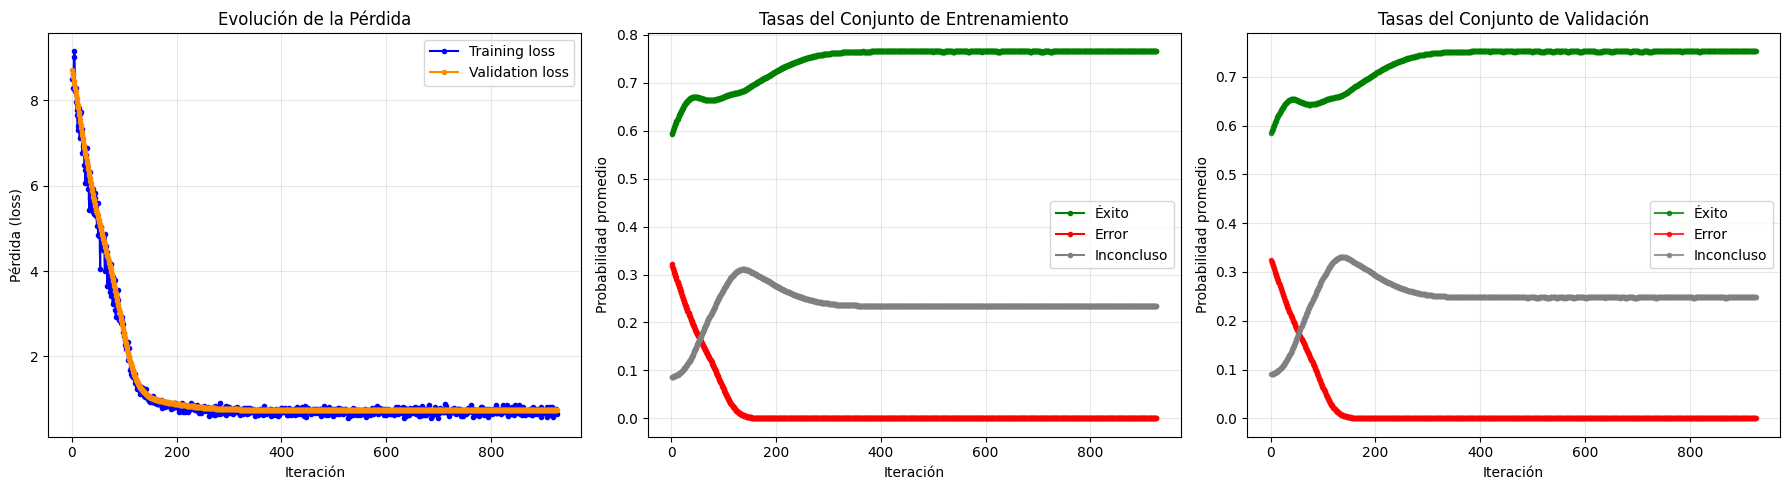

In [13]:
it = len(train_suc_history)

# Visualización de los resultados
plt.figure(figsize=(18, 5))

# 1. Evolución de la pérdida
plt.subplot(1, 3, 1)
plt.plot(range(1, it+1), loss_history, '.-', label="Training loss", color='blue')
plt.plot(range(1, it+1), val_loss_history, '.-', label="Validation loss", color='darkorange')
plt.xlabel("Iteración")
plt.ylabel("Pérdida (loss)")
plt.title("Evolución de la Pérdida")
plt.grid(True, alpha=0.3)
plt.legend()

# 2. Tasas en entrenamiento
plt.subplot(1, 3, 2)
plt.plot(range(1, it+1), train_suc_history, '.-', label="Éxito", color='green')
plt.plot(range(1, it+1), train_err_history, '.-', label="Error", color='red')
plt.plot(range(1, it+1), train_inc_history, '.-', label="Inconcluso", color='gray')
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Entrenamiento")
plt.grid(True, alpha=0.3)
plt.legend()

# 3. Tasas en validación
plt.subplot(1, 3, 3)
plt.plot(range(1, it+1), val_suc_history, '.-', label="Éxito", color='green', alpha=0.8)
plt.plot(range(1, it+1), val_err_history, '.-', label="Error", color='red', alpha=0.8)
plt.plot(range(1, it+1), val_inc_history, '.-', label="Inconcluso", color='gray', alpha=0.8)
plt.xlabel("Iteración")
plt.ylabel("Probabilidad promedio")
plt.title("Tasas del Conjunto de Validación")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

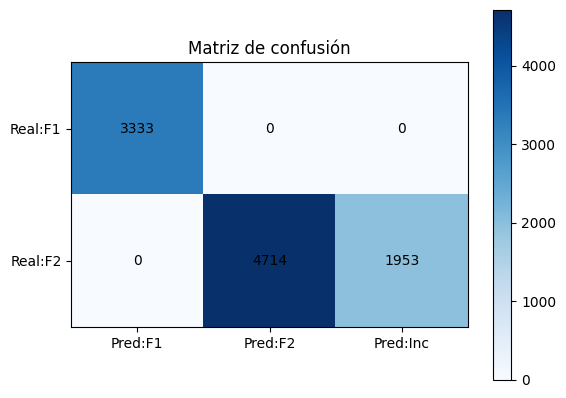

In [14]:
#Matriz de confusión

def predict_label(params, val, actual_label):
    """
    Devuelve la predicción discreta:
      1 => familia 1
      2 => familia 2
      3 => inconcluso


    actual_label se usa para saber qué outcome corresponde a éxito o error.
    """
    probs = get_probabilities(params, val, actual_label)

    p_fam1 = probs[0] + probs[2]
    p_fam2 = probs[1]
    p_inc  = probs[3]

    # Tomamos la mayor de las tres
    idx = np.argmax([p_fam1, p_fam2, p_inc])
    predicted = [1, 2, 3][idx]  # 1=fam1, 2=fam2, 3=inconcluso
    return predicted

def confusion_matrix_inconclusive(params, samples):

    cm = np.zeros((2, 3))
    for (val, actual_label) in samples:
        pred = predict_label(params, val, actual_label)
        row = actual_label - 1  # (1->0, 2->1)
        col = pred - 1          # (1->0, 2->1, 3->2)
        cm[row, col] += 1
    return cm

def plot_confusion_matrix_inconclusive(cm, normalize=False):
    """
    Dibuja la matriz
    """
    cm_display = cm.copy()
    if normalize:
        for i in range(cm_display.shape[0]):
            row_sum = np.sum(cm_display[i, :])
            if row_sum > 0:
                cm_display[i, :] /= row_sum


    fig, ax = plt.subplots()
    im = ax.imshow(cm_display, cmap='Blues', origin='upper')

    # Etiquetas de ejes
    ax.set_xticks([0,1,2])
    ax.set_yticks([0,1])
    ax.set_xticklabels(["Pred:F1","Pred:F2","Pred:Inc"])
    ax.set_yticklabels(["Real:F1","Real:F2"])

    # Texto en cada celda
    for i in range(2):
        for j in range(3):
            val = cm_display[i, j]
            if normalize:
                txt = f"{val*100:.1f}%"
            else:
                txt = f"{val:.0f}"
            ax.text(j, i, txt, ha='center', va='center', color='black')

    plt.colorbar(im, ax=ax)
    plt.title("Matriz de confusión")
    plt.show()


cm_test = confusion_matrix_inconclusive(params, data_test)
plot_confusion_matrix_inconclusive(cm_test, normalize=False)
